In [107]:
%pip install pandas numpy seaborn torch matplotlib scipy openpyxl

Note: you may need to restart the kernel to use updated packages.


In [108]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import scipy

Здесь и дялее в качестве уровня доверия будем использовать значение 0.95

In [109]:
alpha = 0.05

In [110]:
df = pd.read_excel('Book2.xlsx')

In [111]:
df.shape

(60, 24)

In [112]:
df.head()

0.00   0.50    1.00    1.50    2.00   3.00   3.33   3.66   4.00   4.33   \
0      0  407.0  1000.0  1200.0  1360.0   1750   1540   1660   1540   1950   
1      0  121.0   225.0   708.0  1440.0   2510   1750   1760   1850   1770   
2      0  157.0   453.0   731.0   841.0    911    972    951    968    926   
3      0  297.0   508.0  1030.0  1140.0   1480   1480   1410   1360   1200   
4      0  136.0   195.0   640.0  1260.0   1530   1440   1500   1620   1600   

   ...  6.00   7.00   8.00   10.00  12.00  16.00  24.00  48.00  72.00  96.00  
0  ...   1080   1050   1060    872    945    893    579  181.0   51.6   13.8  
1  ...   1240   1250   1220   1320   1140   1030    741  323.0   89.8   32.9  
2  ...    717    673    654    514    524    477    260   75.5   21.9    0.0  
3  ...    893    847    900    825    677    525    472  245.0  101.0   44.2  
4  ...   1110    946    998   1060    860    881    756  526.0  271.0  147.0  

[5 rows x 24 columns]

In [113]:
x = np.array([float(elem) for elem in df.columns])
y = df.iloc[0,]
for interp in [scipy.interpolate.CubicSpline, scipy.interpolate.PchipInterpolator,
               scipy.interpolate.make_interp_spline, scipy.interpolate.interp1d]:
    func = interp(x, y)
    x_cont = np.linspace(0, np.max(x), 2000)
    # plt.title(f"{interp.__name__}")
    # plt.plot(x, y)
    # plt.plot(x_cont, func(x_cont))
    # plt.show()

In [114]:
interpolator = scipy.interpolate.PchipInterpolator

In [115]:
squares = []
integrator = scipy.integrate.quad_vec
for i in range(len(df)):
    x = [float(elem) for elem in df.select_dtypes(include=['float64', 'int64'])]
    y = df.iloc[i,]
    func = interpolator(x, y)
    x_cont = np.linspace(0, np.max(x), 2000)
    area, eps = integrator(func, 0, np.max(x))
    squares.append(area)
    # plt.plot(x, y)
    # plt.plot(x_cont, func(x_cont))
    # plt.show()
df['area'] = squares

In [116]:
squares = np.array(df['area'])
squares_log = np.log(squares)
scipy.stats.normaltest(squares_log)

NormaltestResult(statistic=np.float64(11.975523670769851), pvalue=np.float64(0.0025092739380717217))

<Axes: >

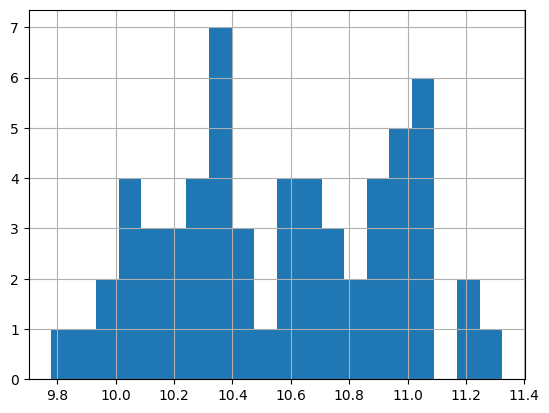

In [117]:
np.log(df['area']).hist(bins=20)

Попробуем для каждого временного ряда найти точку, где достигается максимум концентрации

In [118]:
M = []
for i in range(len(df)):
    x = [float(elem) for elem in df.drop('area', axis=1).columns]
    y = df.iloc[i,][:-1]
    M.append(x[np.argmax(y)])
df['max'] = M

Построим гистограмму для распределения этих точек

<Axes: >

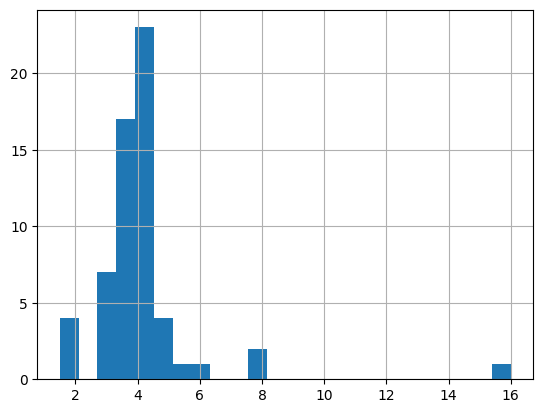

In [119]:
df['max'].hist(bins=len(df.columns) - 2)

In [120]:
m = df['max'].mean()
m

np.float64(4.114)

Как видно, среднее значение очень близко к моде

In [121]:
def check_fit(x, y, f1, f2, alpha=0.05, make_plots=True):
    m = x[np.argmax(y)]
    x1 = x[np.where(x <= m)]
    x2 = x[np.where(x >= m)]
    y1 = y[np.where(x <= m)]
    y2 = y[np.where(x >= m)]
    popt1, _ = scipy.optimize.curve_fit(f1, x1, y1)
    popt2, _ = scipy.optimize.curve_fit(f2, x2, y2)
    y_pred = np.array(list(f1(x1, *popt1))[:-1] + list(f2(x2, *popt2)))
    _, pvalue = scipy.stats.normaltest(y - y_pred)
    if make_plots:
        plt.plot(x, y)
        plt.plot(x, y_pred, color='red' if pvalue < alpha else 'green')
    plt.show()
    return pvalue, popt1, popt2

Попробуем использовать следующую модель для предсказания концентрации от времени:

$
f(x)=
\begin{cases}
ax^2 + bx + c, x < m \\\ 
e^{ax+b} (x^2 +cx + d), x \geq m
\end{cases}
$,   где $m$ - точка максимума концентрации

Здесь и далее, если коэффициент имеет индекс, то первый индекс означет, что это коэффициент для первой модели, в противном случае - для второй

In [122]:
def f1(x, a, b, c):
    return a * x ** 2 + b * x + c

In [123]:
def f2(x, a, b, c, d):
    return np.exp(a * x + b) * (x ** 2 + x * c + d)

In [124]:
pvalues = []
a1 = []
b1 = []
c1 = []
a2 = []
b2 = []
c2 = []
d2 = []

Проверим нашу модель на состоятельность

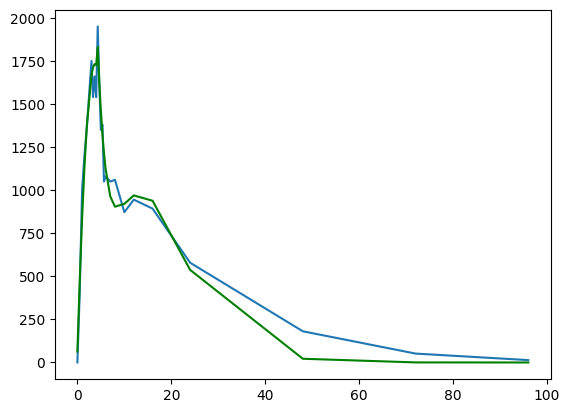

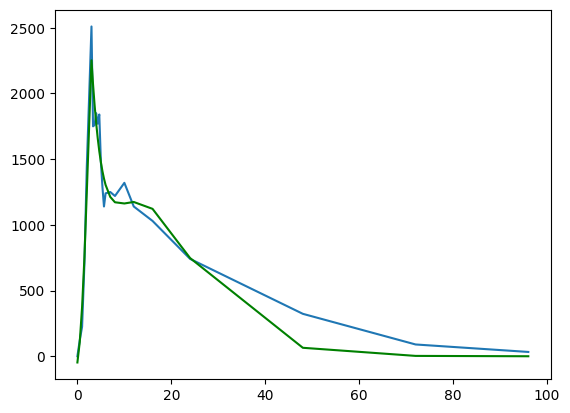

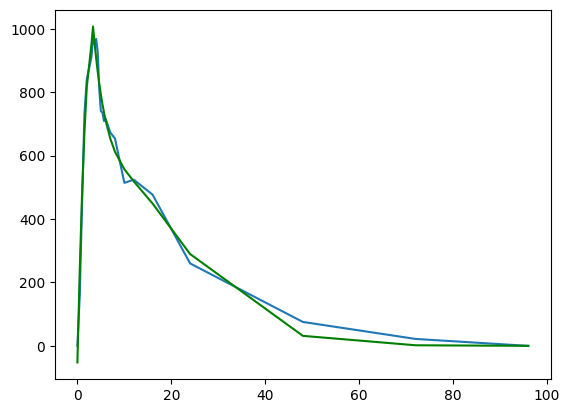

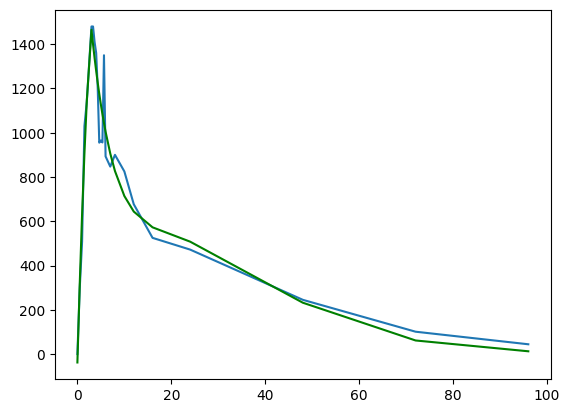

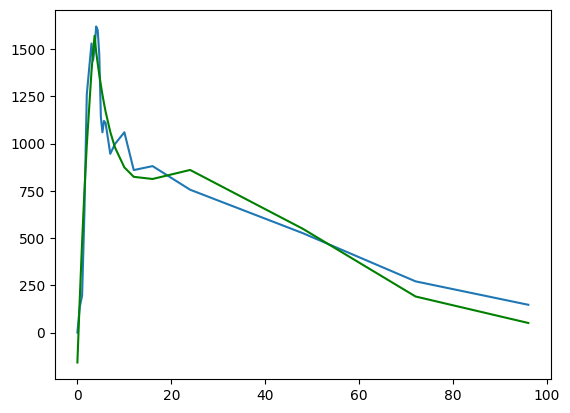

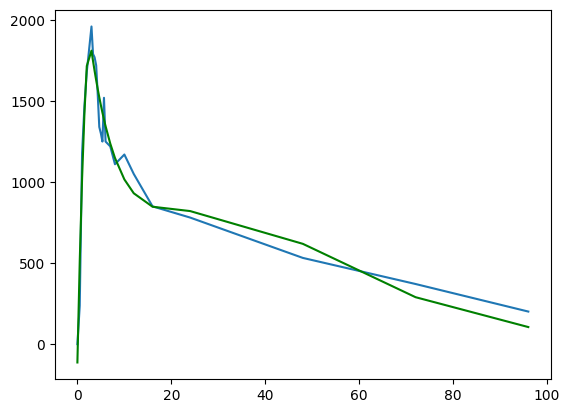

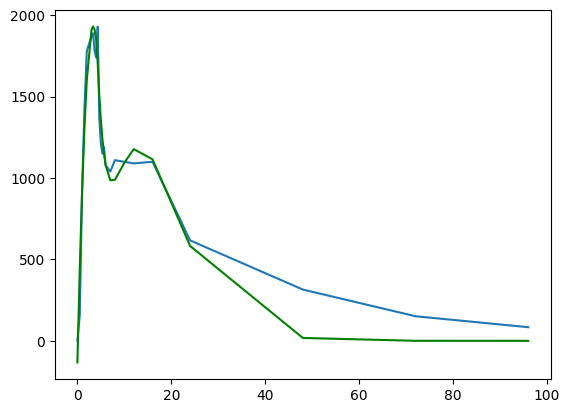

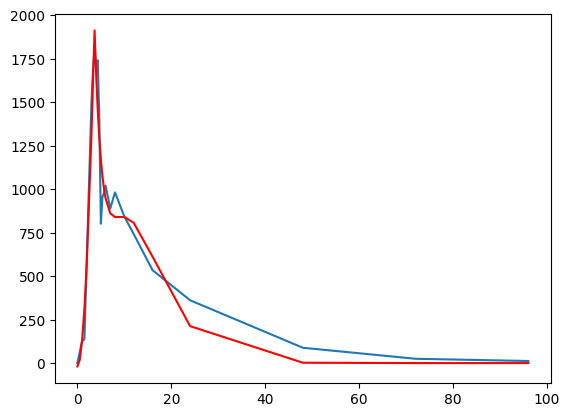

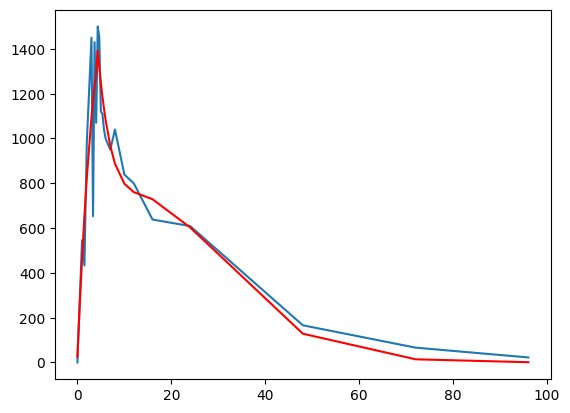

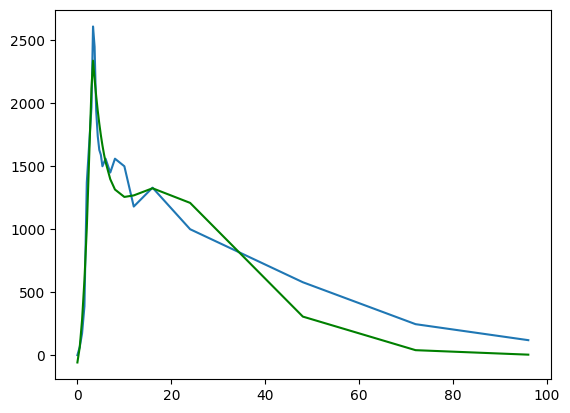

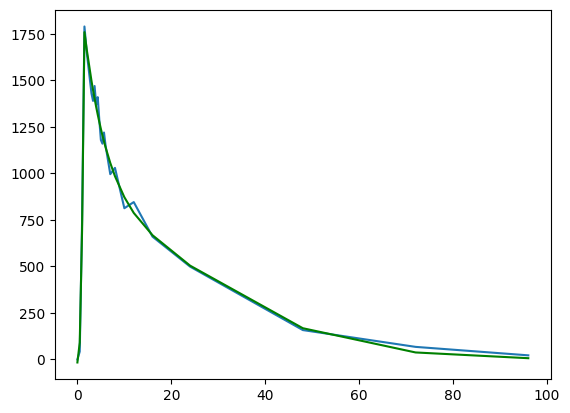

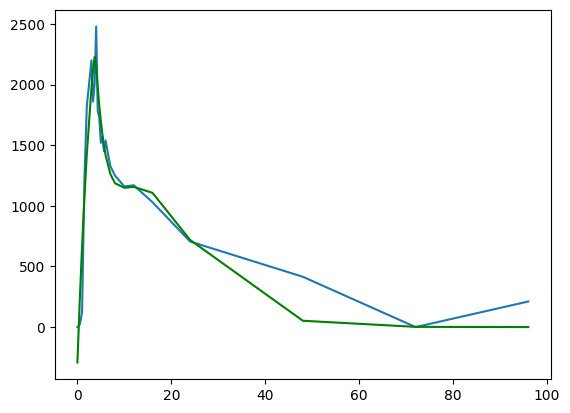

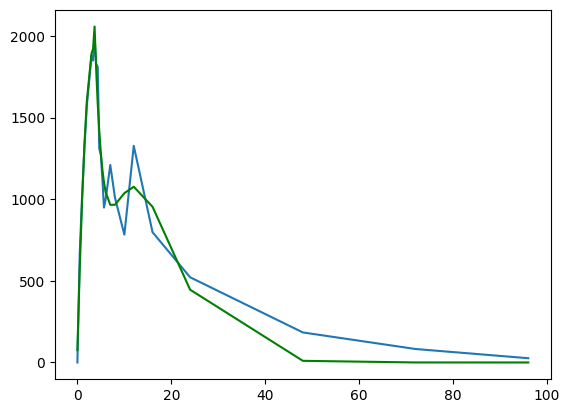

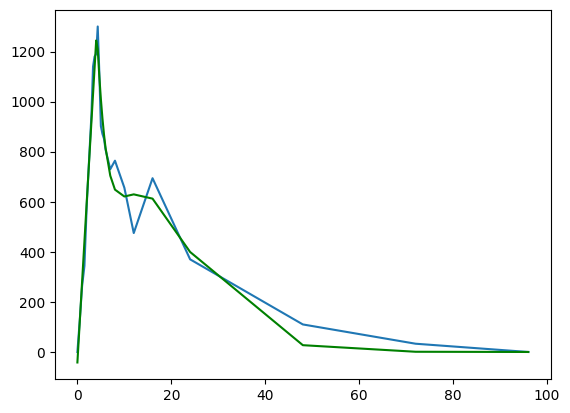

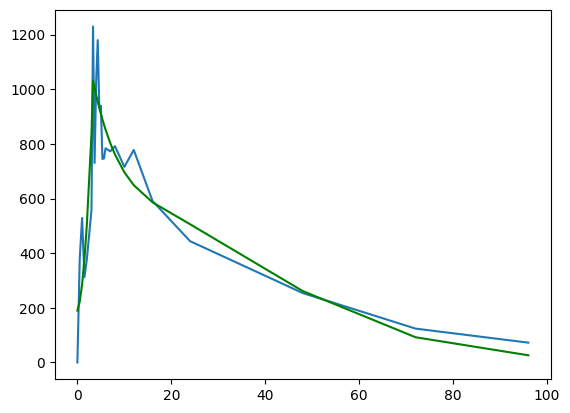

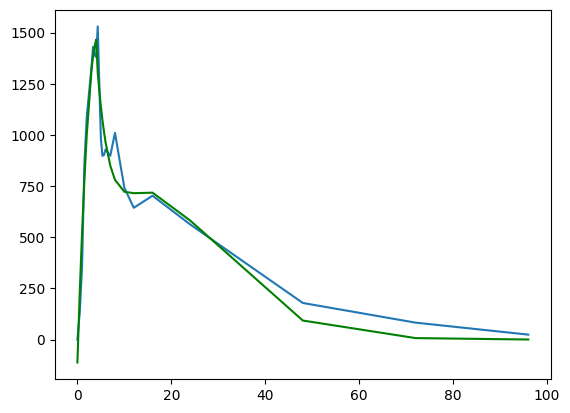

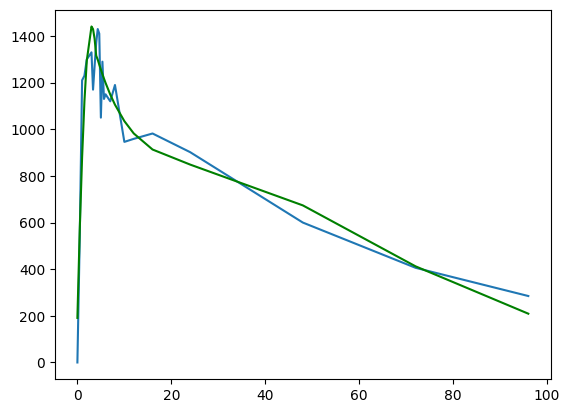

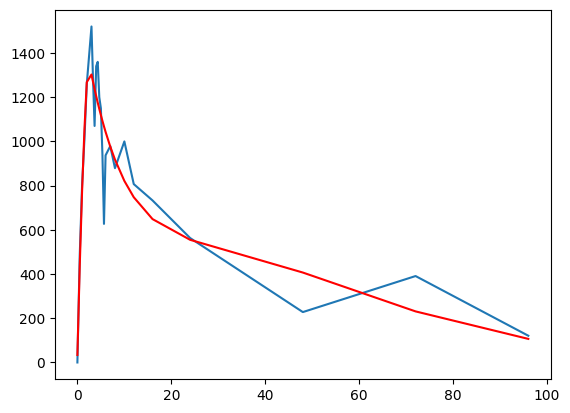

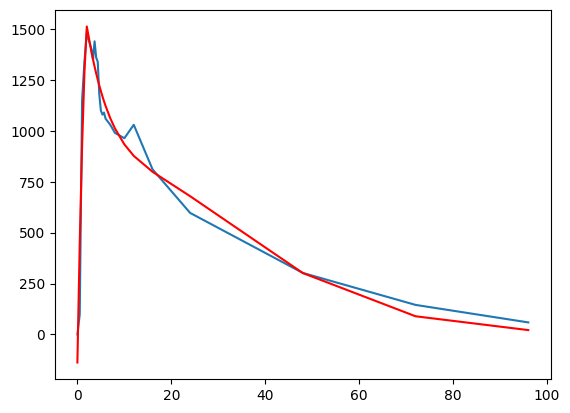

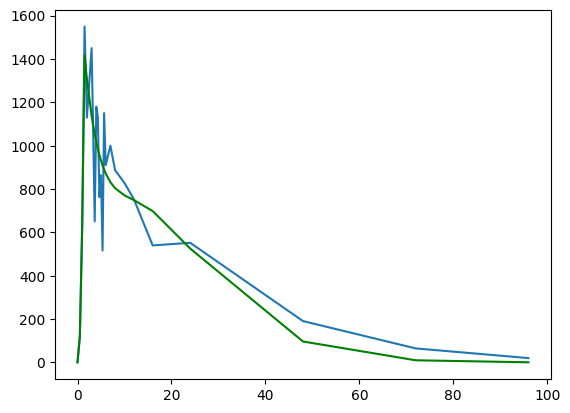

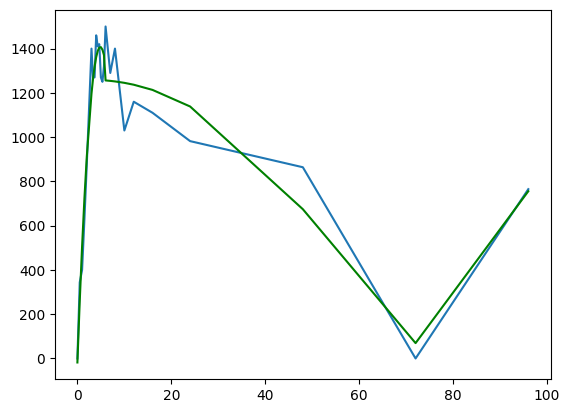

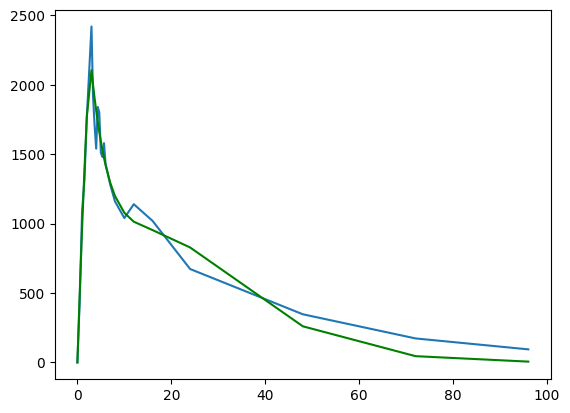

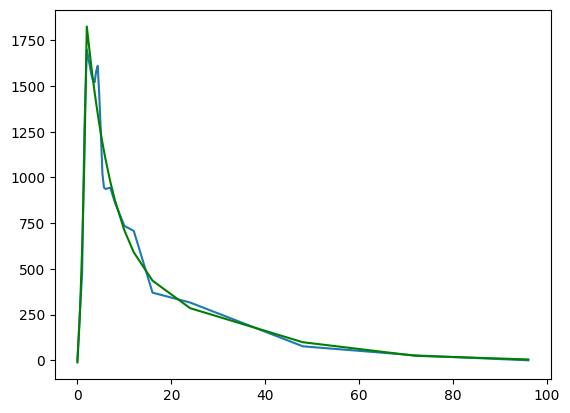

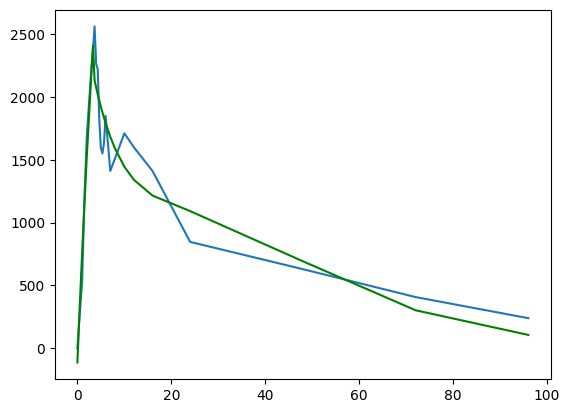

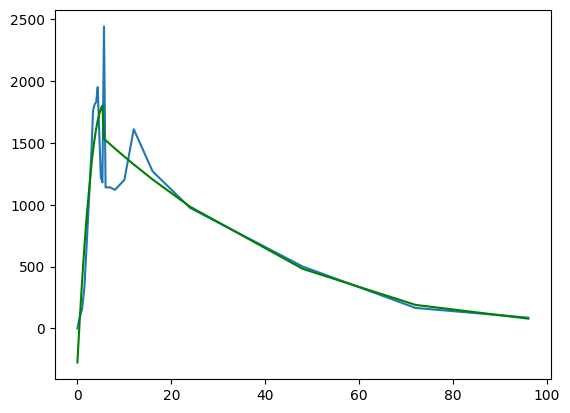

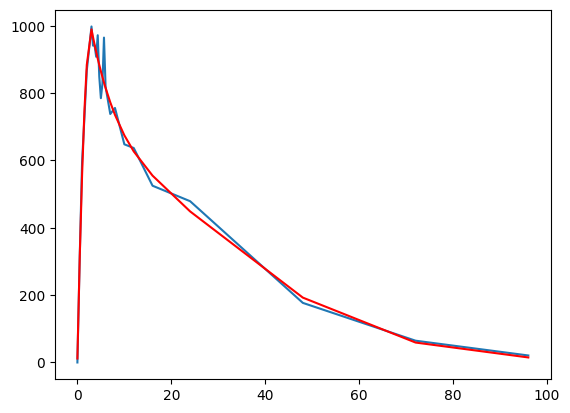

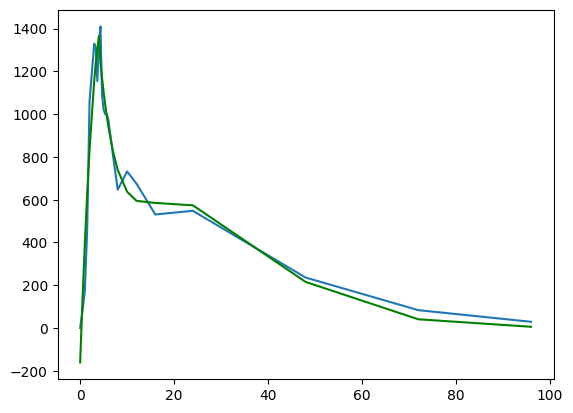

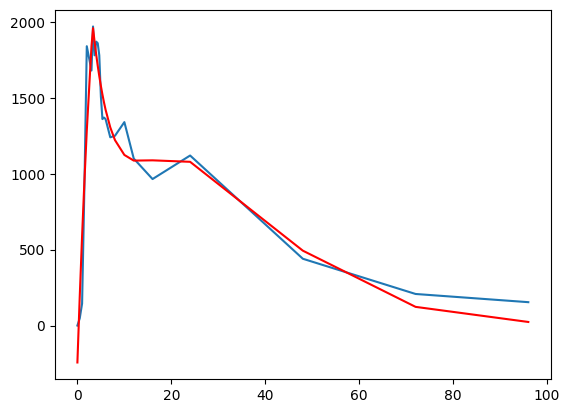

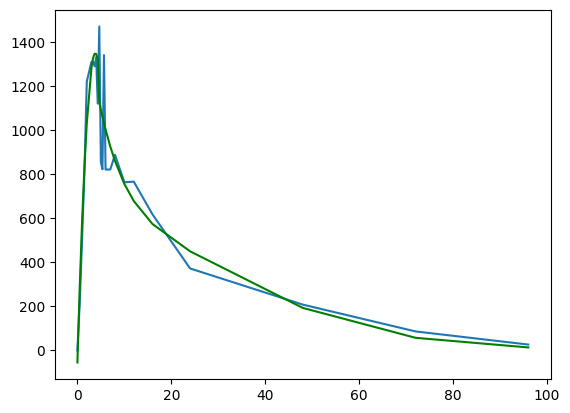

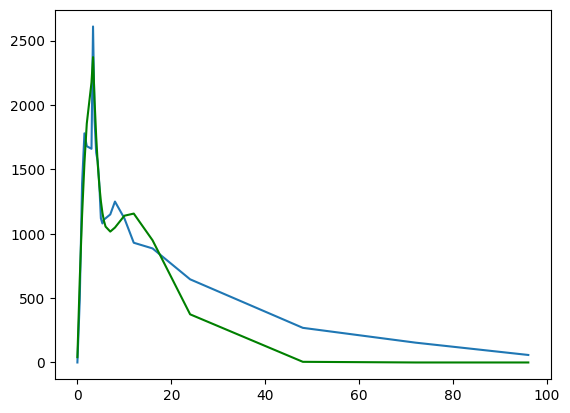

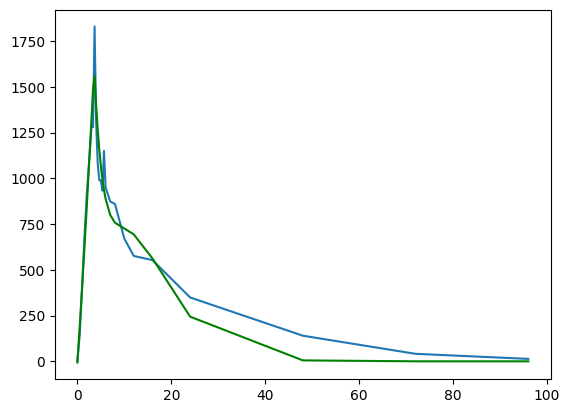

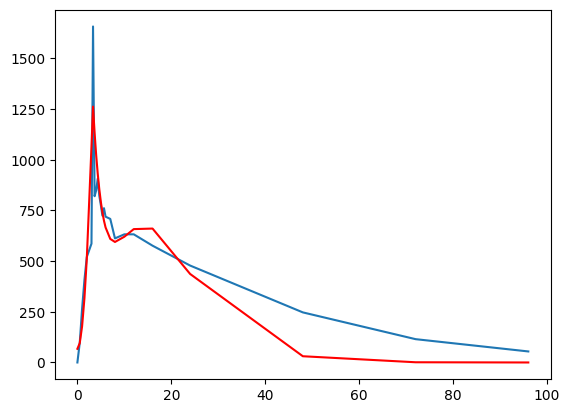

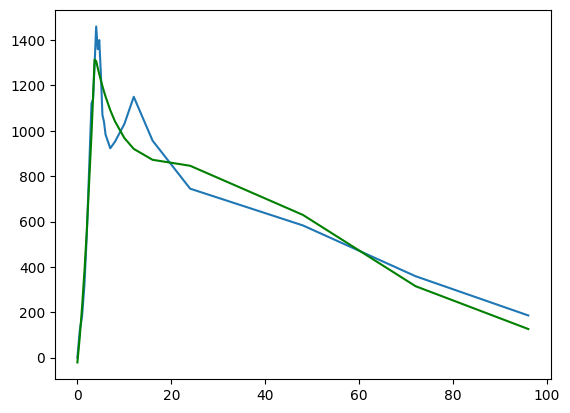

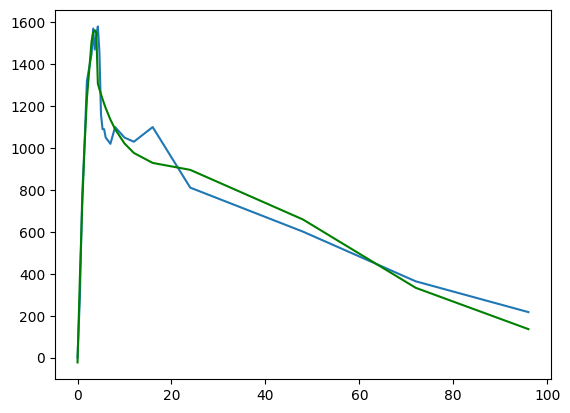

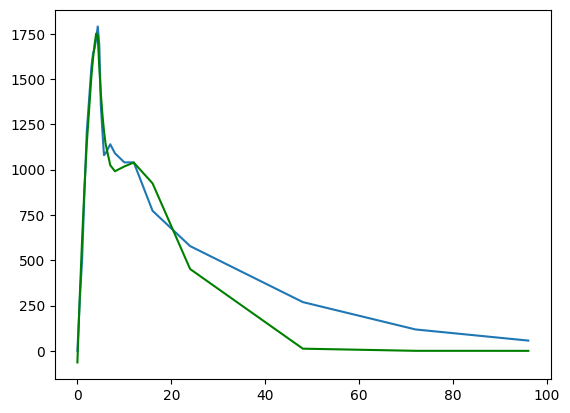

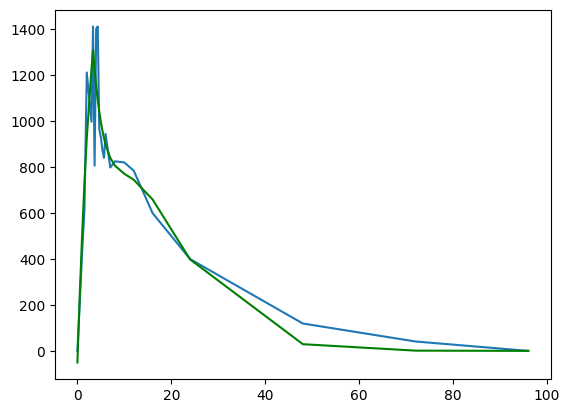

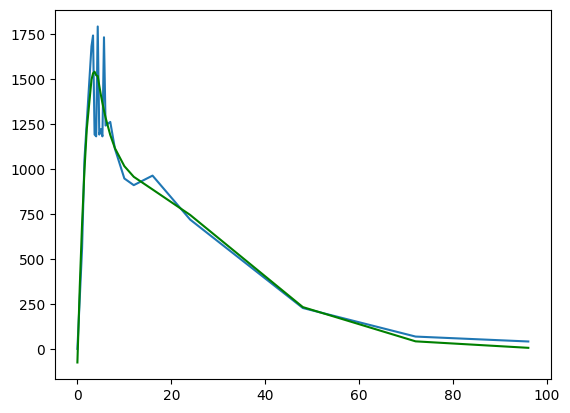

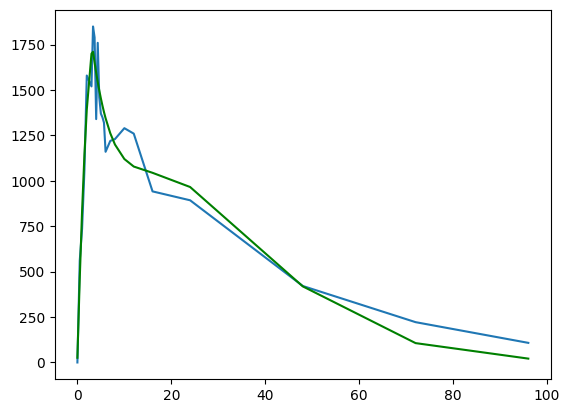

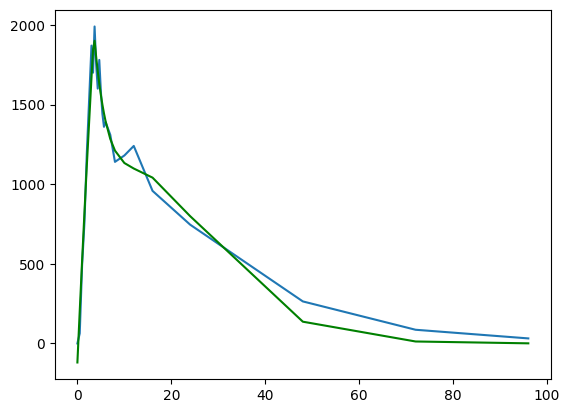

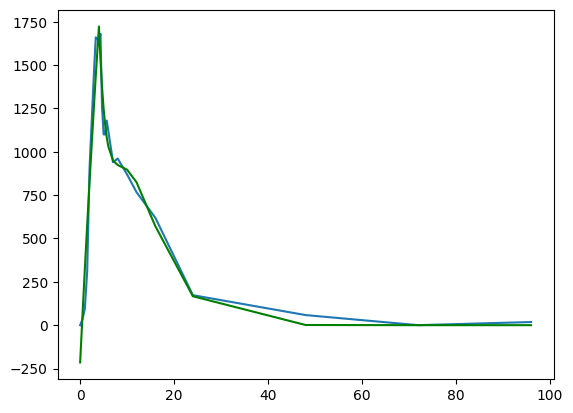

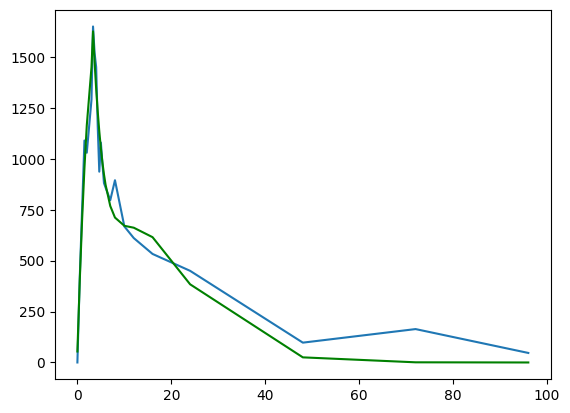

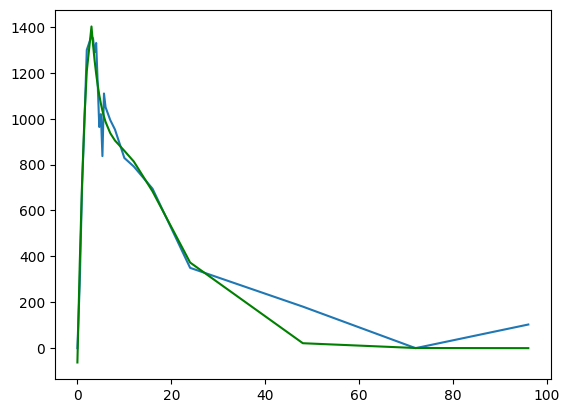

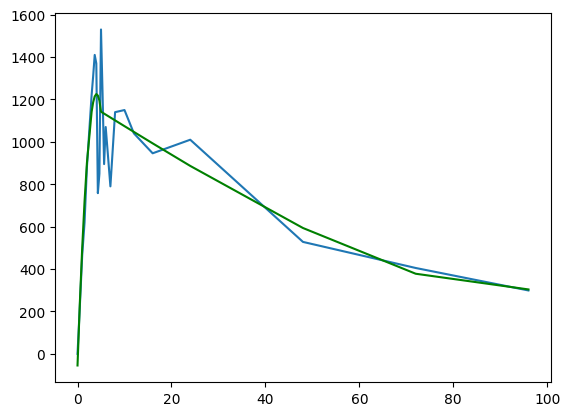

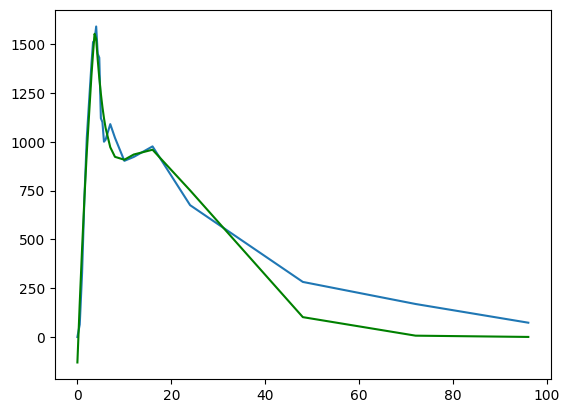

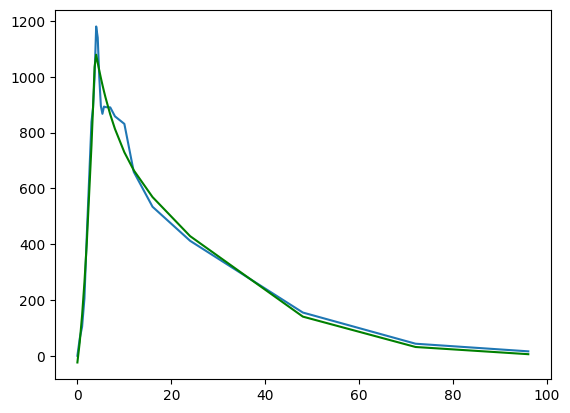

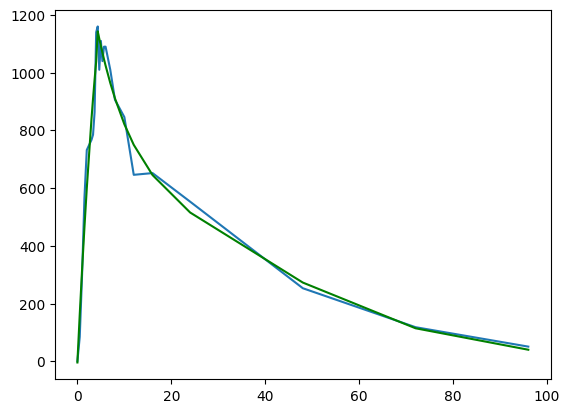

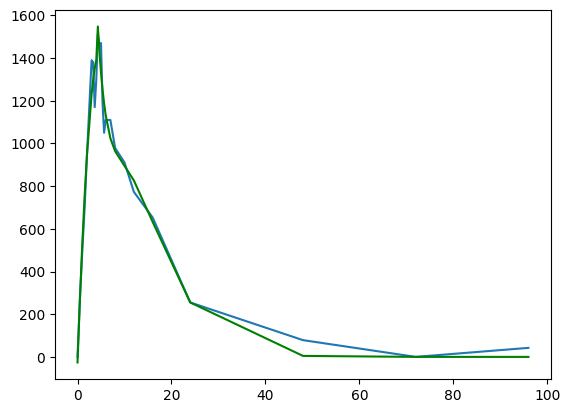

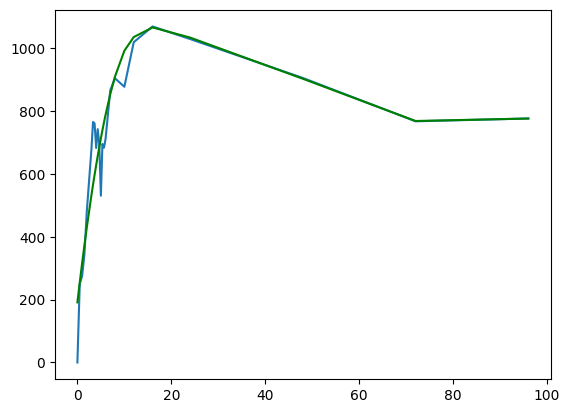

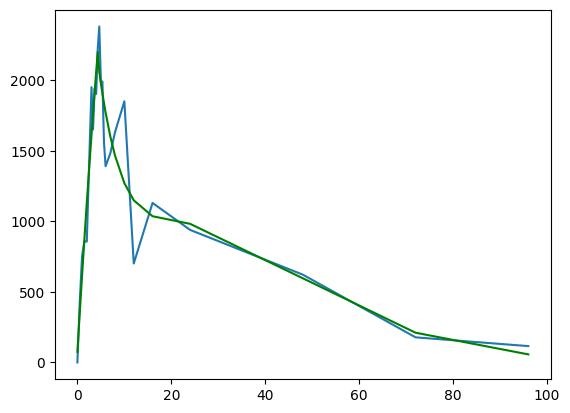

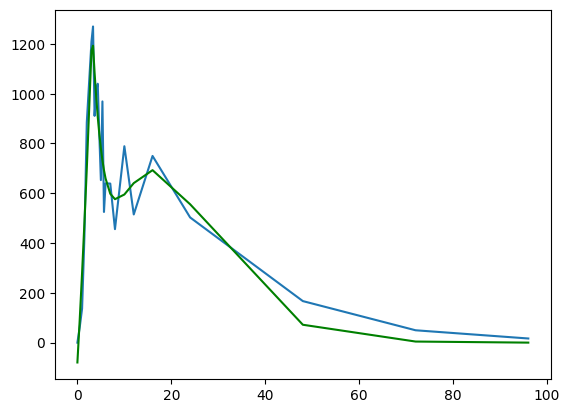

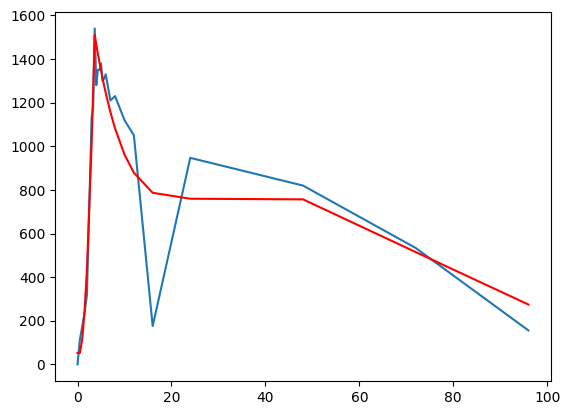

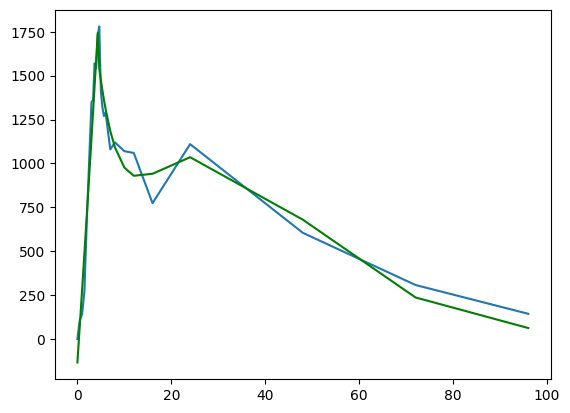

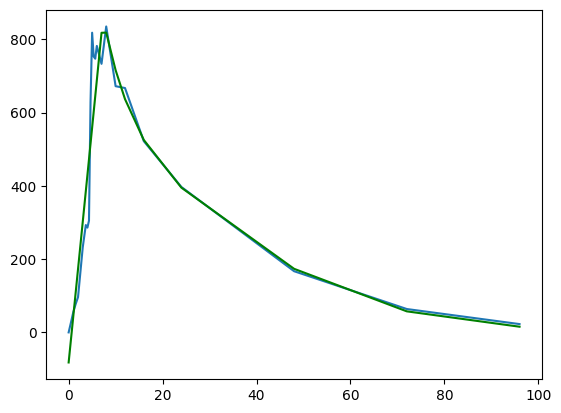

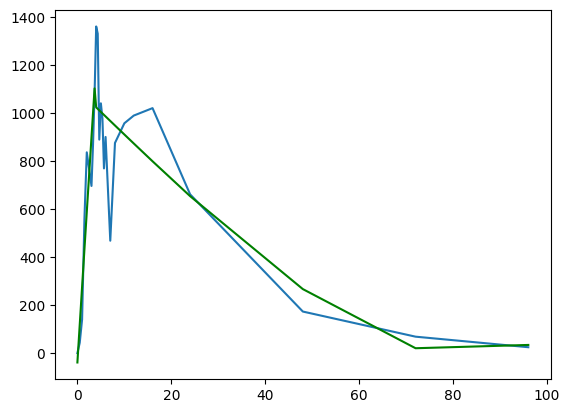

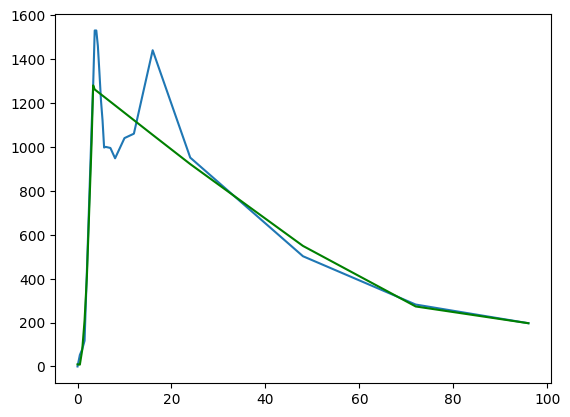

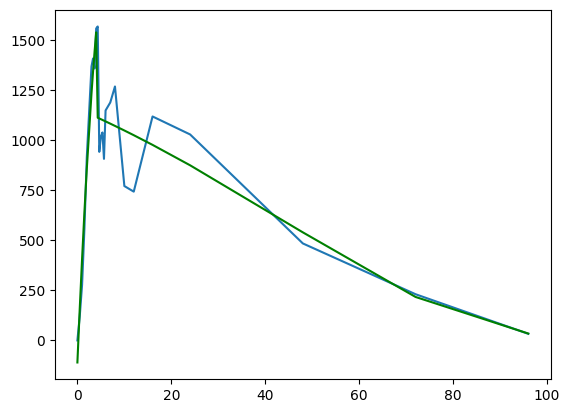

In [125]:
for i in range(len(df)):
    x = np.array([float(elem) for elem in df.drop(['area', 'max'], axis=1).columns])
    y = np.array(df.iloc[i,][:-2])
    try:
        pvalue, popt1, popt2 = check_fit(x, y, f1, f2, make_plots=True)
        pvalues.append(pvalue)
        a1_, b1_, c1_ = popt1
        a1.append(a1_)
        b1.append(b1_)
        c1.append(c1_)
        a2_, b2_, c2_, d2_ = popt2
        a2.append(a2_)
        b2.append(b2_)
        c2.append(c2_)
        d2.append(d2_)
    except RuntimeError:
        pass
a1 = np.array(a1)
b1 = np.array(b1)
c1 = np.array(c1)
a2 = np.array(a2)
b2 = np.array(b2)
c2 = np.array(c2)
d2 = np.array(d2)

Визуально модель выглядит как подходящая, посмотрим на значение теста на нормальность остатков

In [126]:
pvalues = np.array(pvalues)
success = pvalues > alpha
np.mean(success)

np.float64(0.8571428571428571)

То есть, примерно в 86% случаев остатки являются нормальными

Попробуем отследить связь между коэффициентами в моделях. Это может быть полезно как для упрощения, так и для предсказания модели.

In [127]:
def plot_with_sort(x, y):
    pairs = sorted(zip(x, y), key=lambda elem: elem[0])
    x = [elem[0] for elem in pairs]
    y = [elem[1] for elem in pairs]
    plt.plot(x, y)

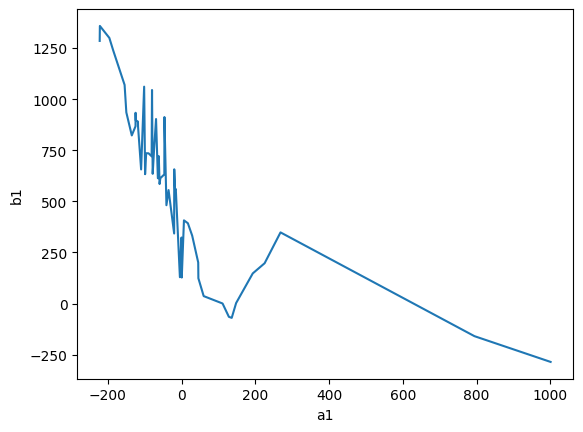

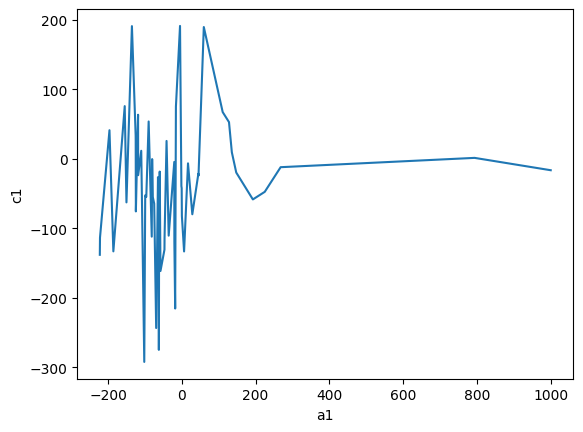

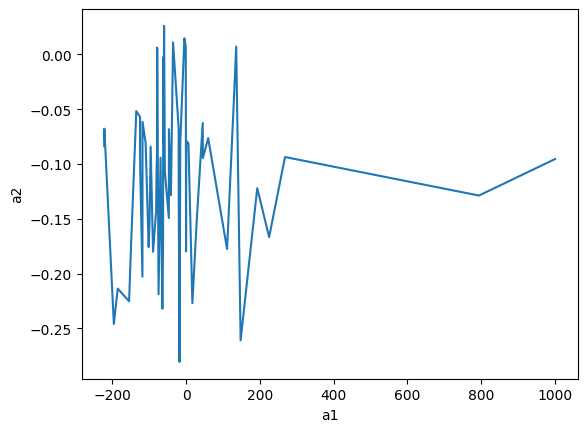

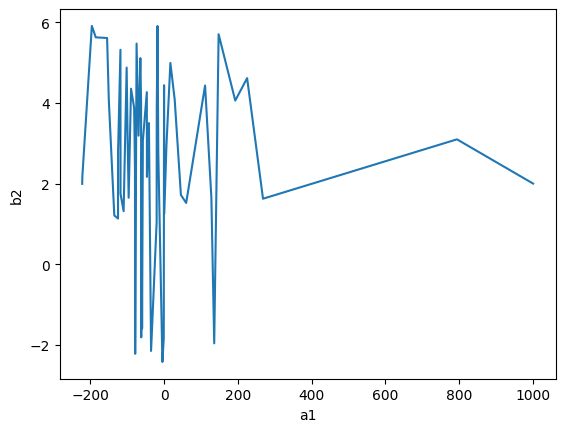

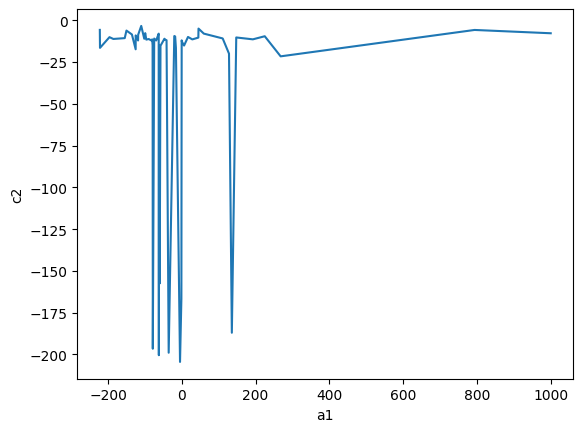

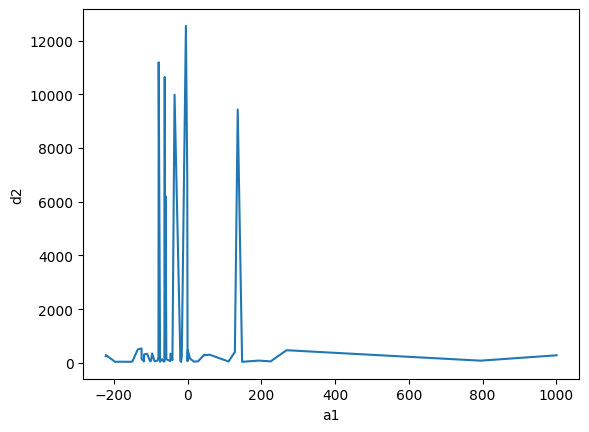

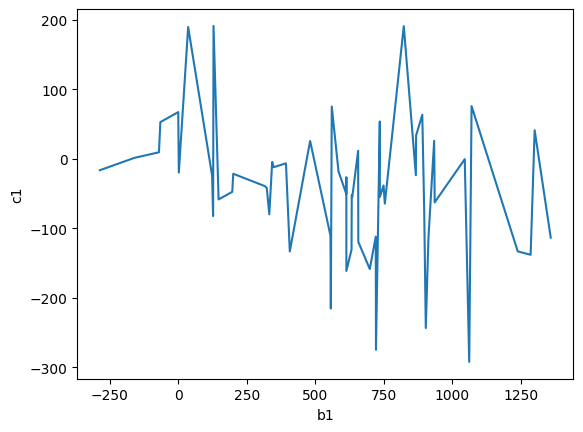

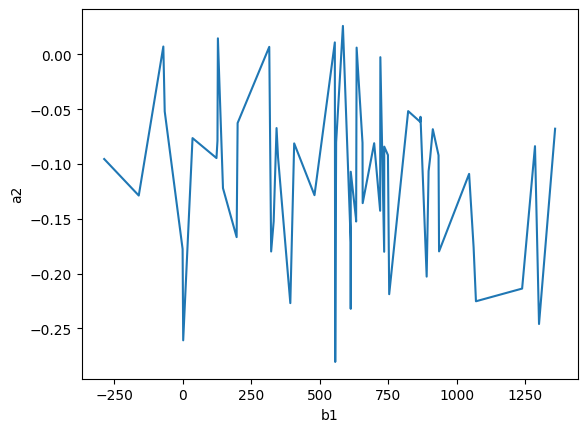

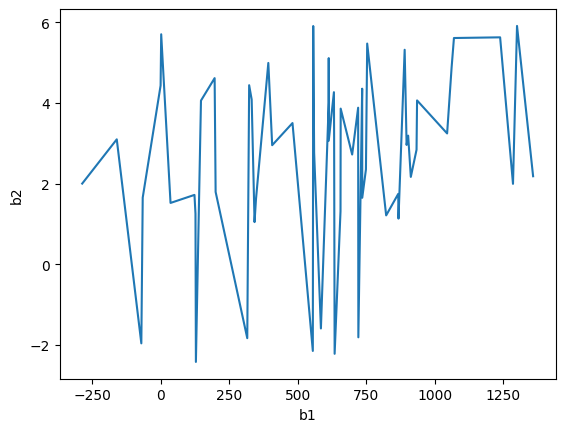

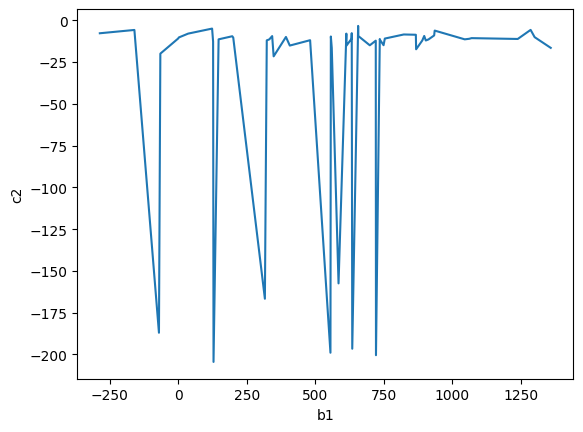

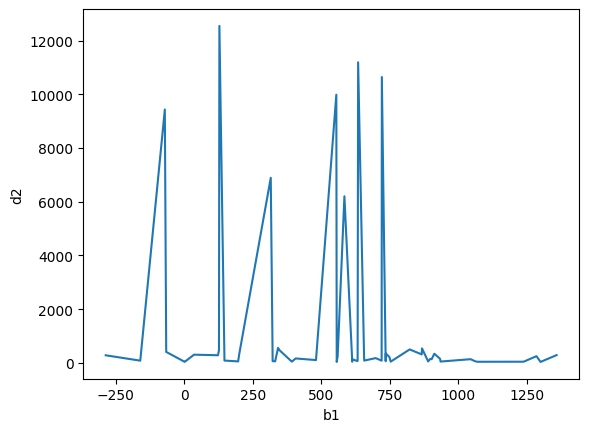

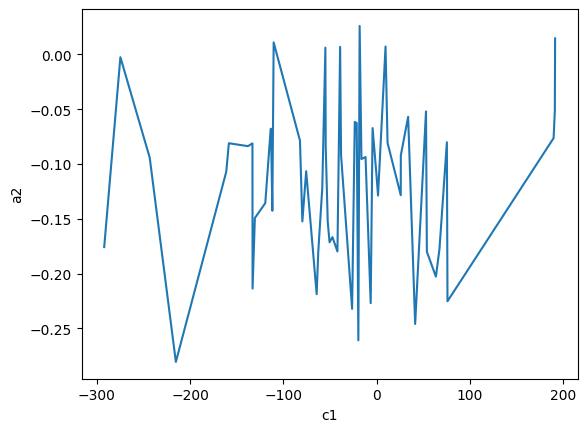

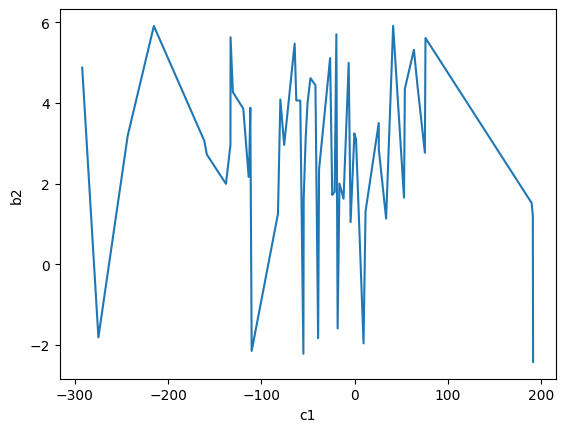

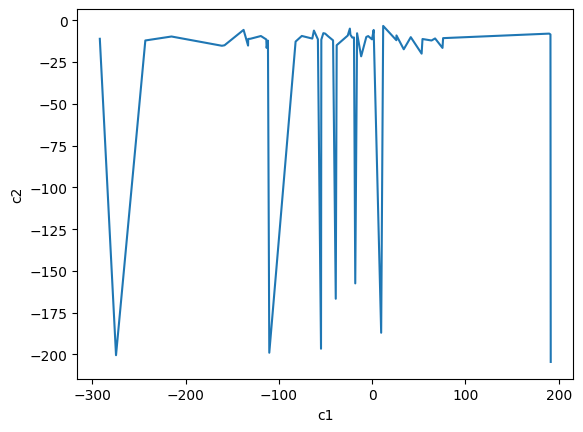

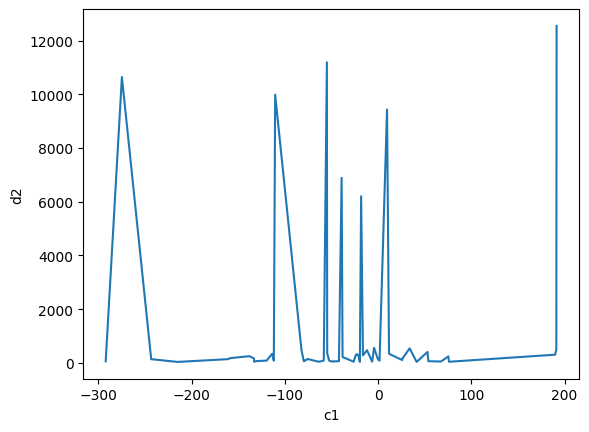

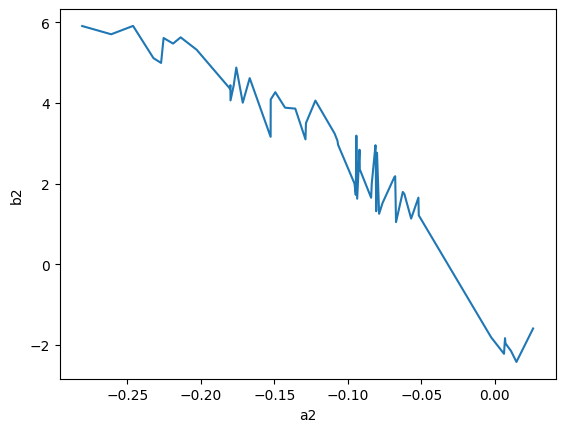

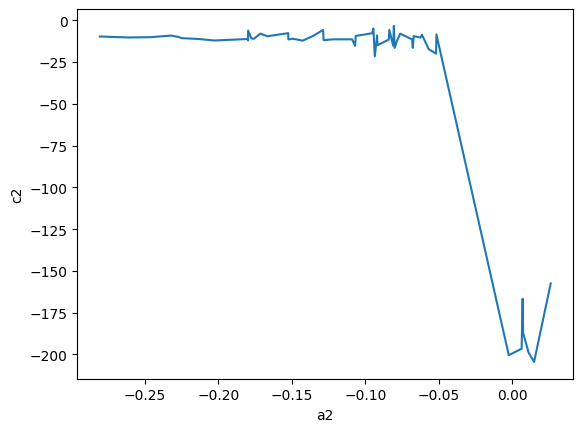

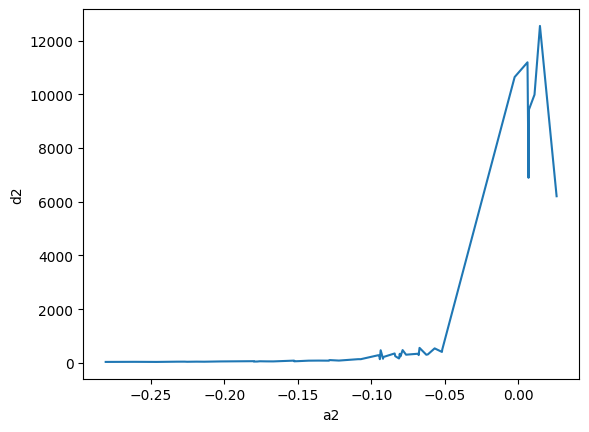

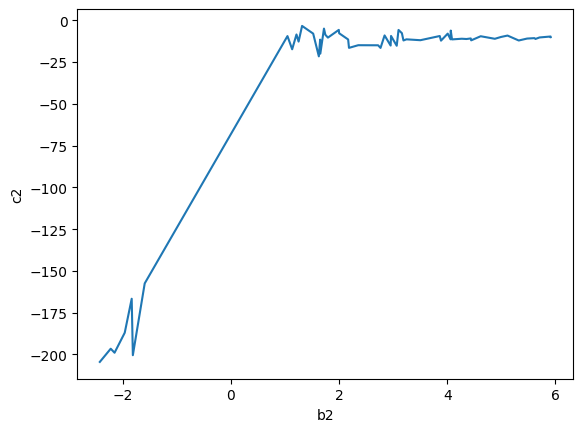

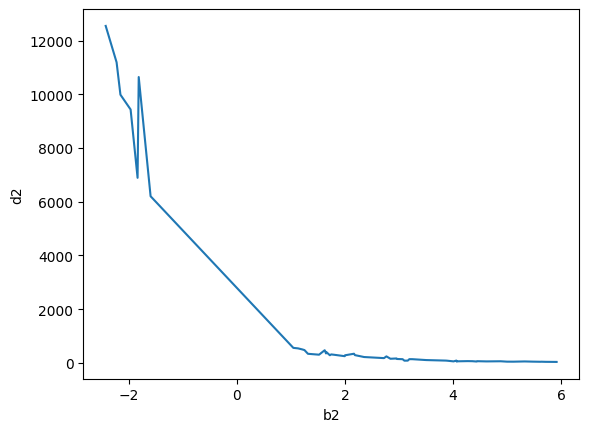

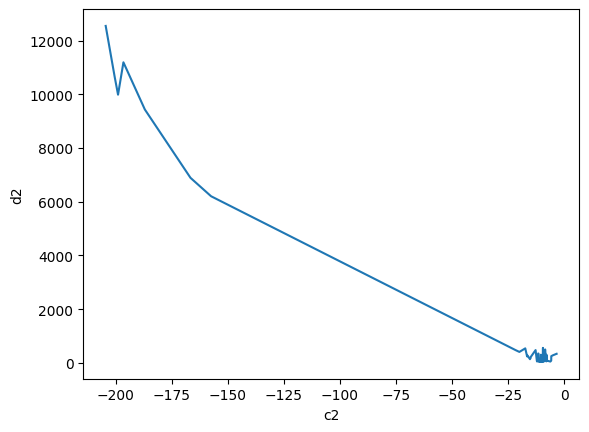

In [128]:
coords = {'a1': a1, 'b1': b1, 'c1': c1, 'a2': a2, 'b2': b2, 'c2': c2, 'd2': d2}
for i in range(len(coords)):
    for j in range(i+1, len(coords)):
        x = list(coords.keys())[i]
        y = list(coords.keys())[j]
        plt.xlabel(x)
        plt.ylabel(y)
        plot_with_sort(coords[x], coords[y])
        plt.show()

Зависимость коэффициентов от  *_2 от b_1

In [129]:
x = b1
y1 = a2
y2 = b2
y3 = c2
y4 = d2

In [130]:
points = zip(x, y1, y2, y3, y4)

In [131]:
points = sorted(points, key=lambda elem: elem[0])

In [132]:
def get_col(table, col_number):
    return np.fromiter(map(lambda elem: elem[col_number] , table), dtype=float)

In [133]:
x = get_col(points, 0)
y1 = get_col(points, 1)
y2 = get_col(points, 2)
y3 = get_col(points, 3)
y4 = get_col(points, 4)

[Text(0.5, 0, 'b1'), Text(0, 0.5, 'd2')]

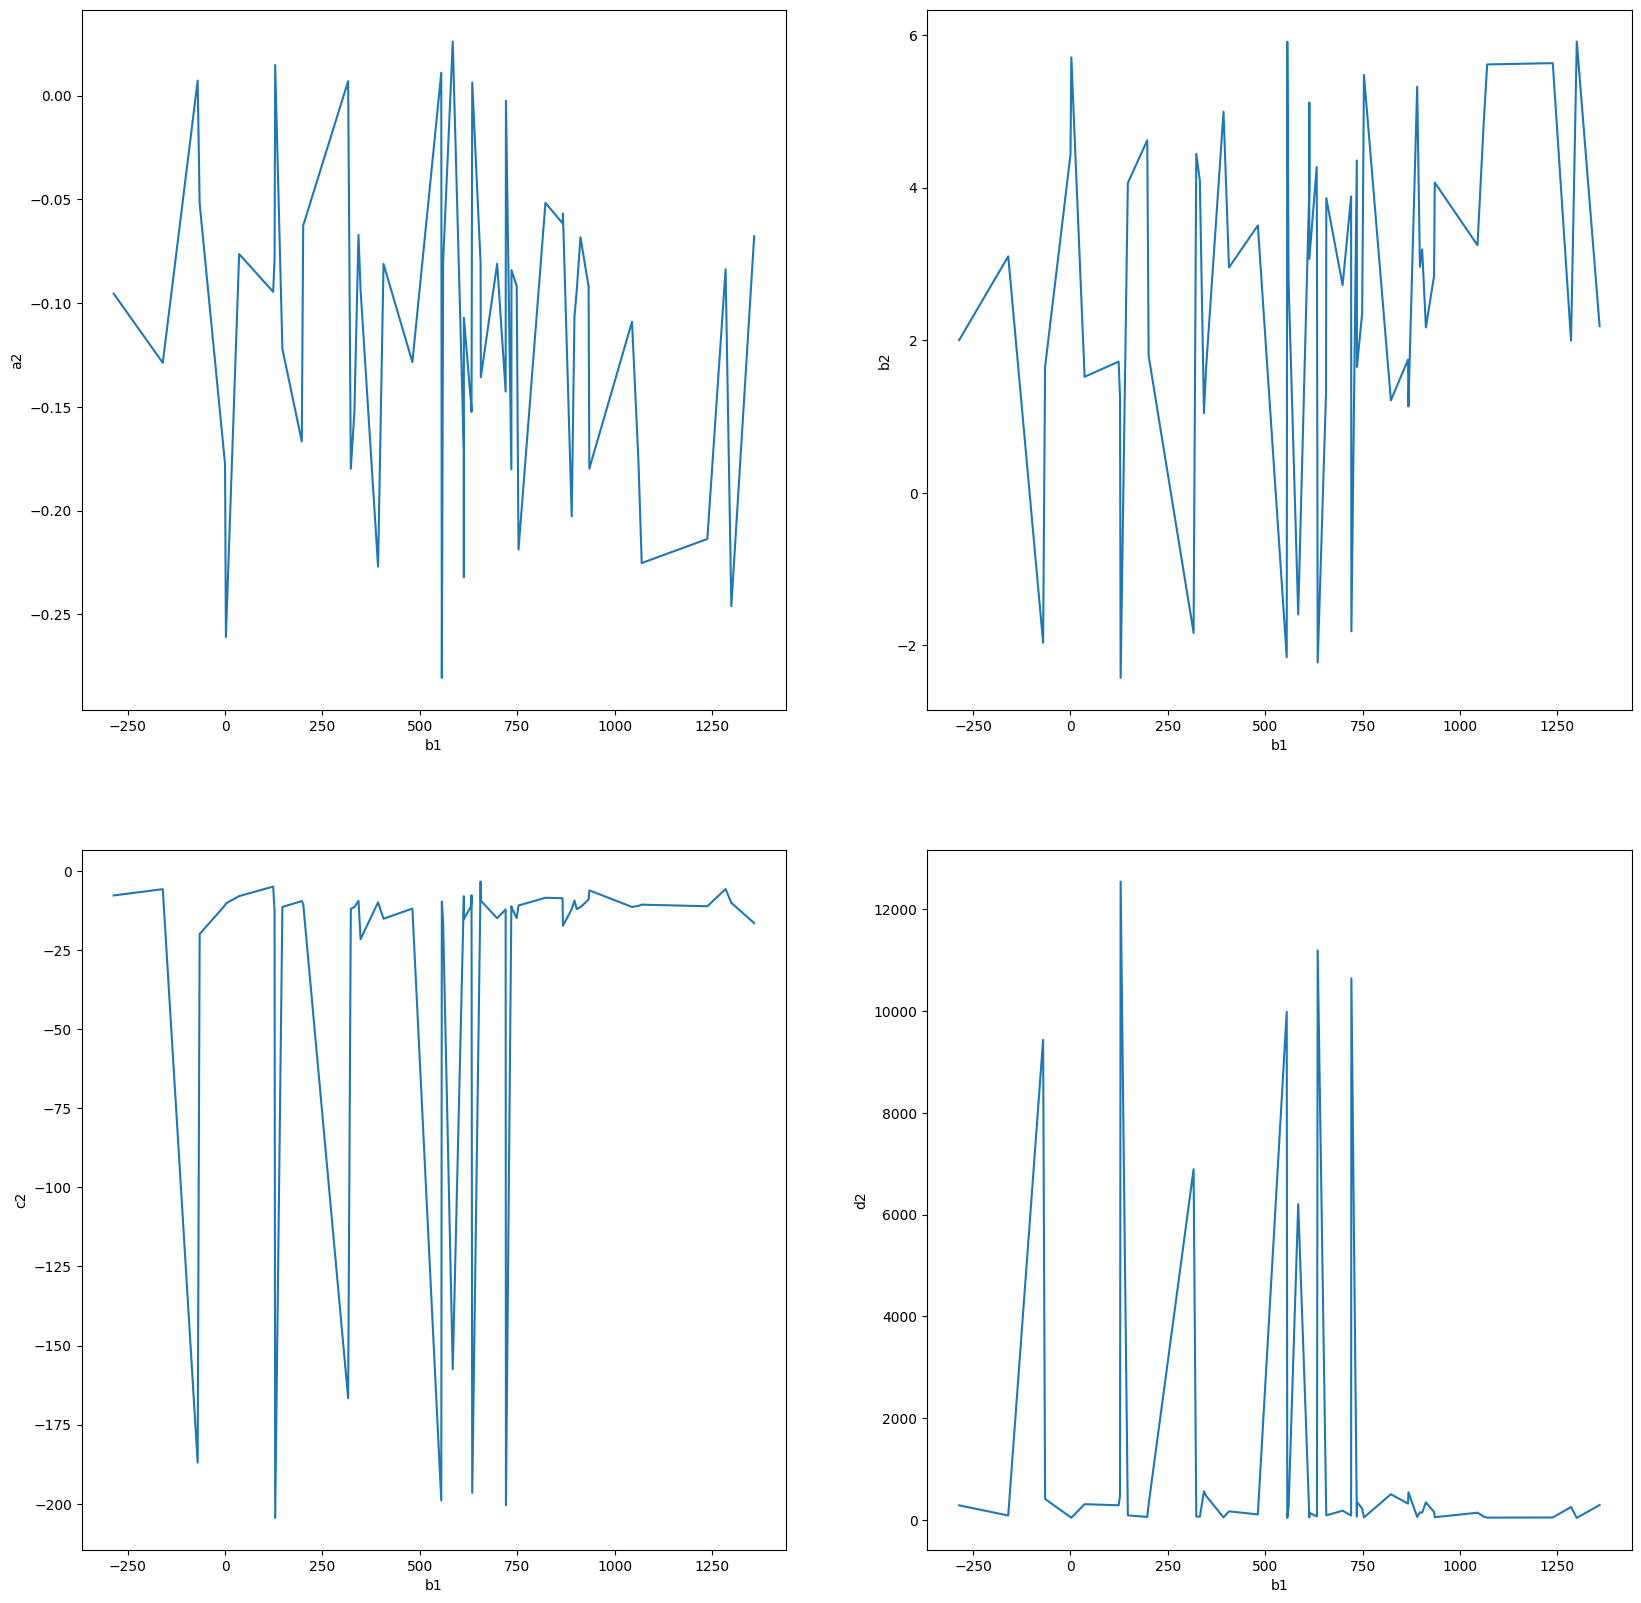

In [134]:
fig, axs = plt.subplots(2, 2, figsize=(20, 20))
axs[0, 0].plot(x, y1)
axs[0, 0].set(xlabel='b1', ylabel='a2')

axs[0, 1].plot(x, y2)
axs[0, 1].set(xlabel='b1', ylabel='b2')

axs[1, 0].plot(x, y3)
axs[1, 0].set(xlabel='b1', ylabel='c2')

axs[1, 1].plot(x, y4)
axs[1, 1].set(xlabel='b1', ylabel='d2')

На графиках можно видеть сегменты, где $b_1 < 0$ и $b_1 \geq 0$. В первом случае виден линейный характер зависимости. Пока исследуем вторую половину.

In [135]:
len(set(b1))

56

In [136]:
(x == y2).all()

np.False_

То есть, $b_1$ и $b_2$ полностью идентичны

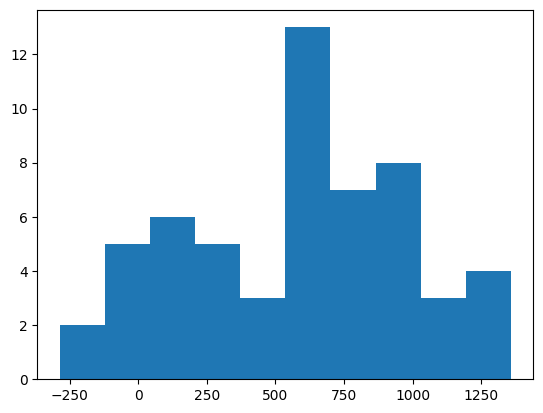

In [137]:
plt.hist(x)
plt.show()

Заметим, что большая часть значений лежит правее нуля. Значит, можно считать всё, что левее нуля, выбросами.

In [138]:
y1 = y1[x >= 0]
y2 = y2[x >= 0]
y3 = y3[x >= 0]
y4 = y4[x >= 0]
x = x[x >= 0]

[Text(0.5, 0, 'b1'), Text(0, 0.5, 'd2')]

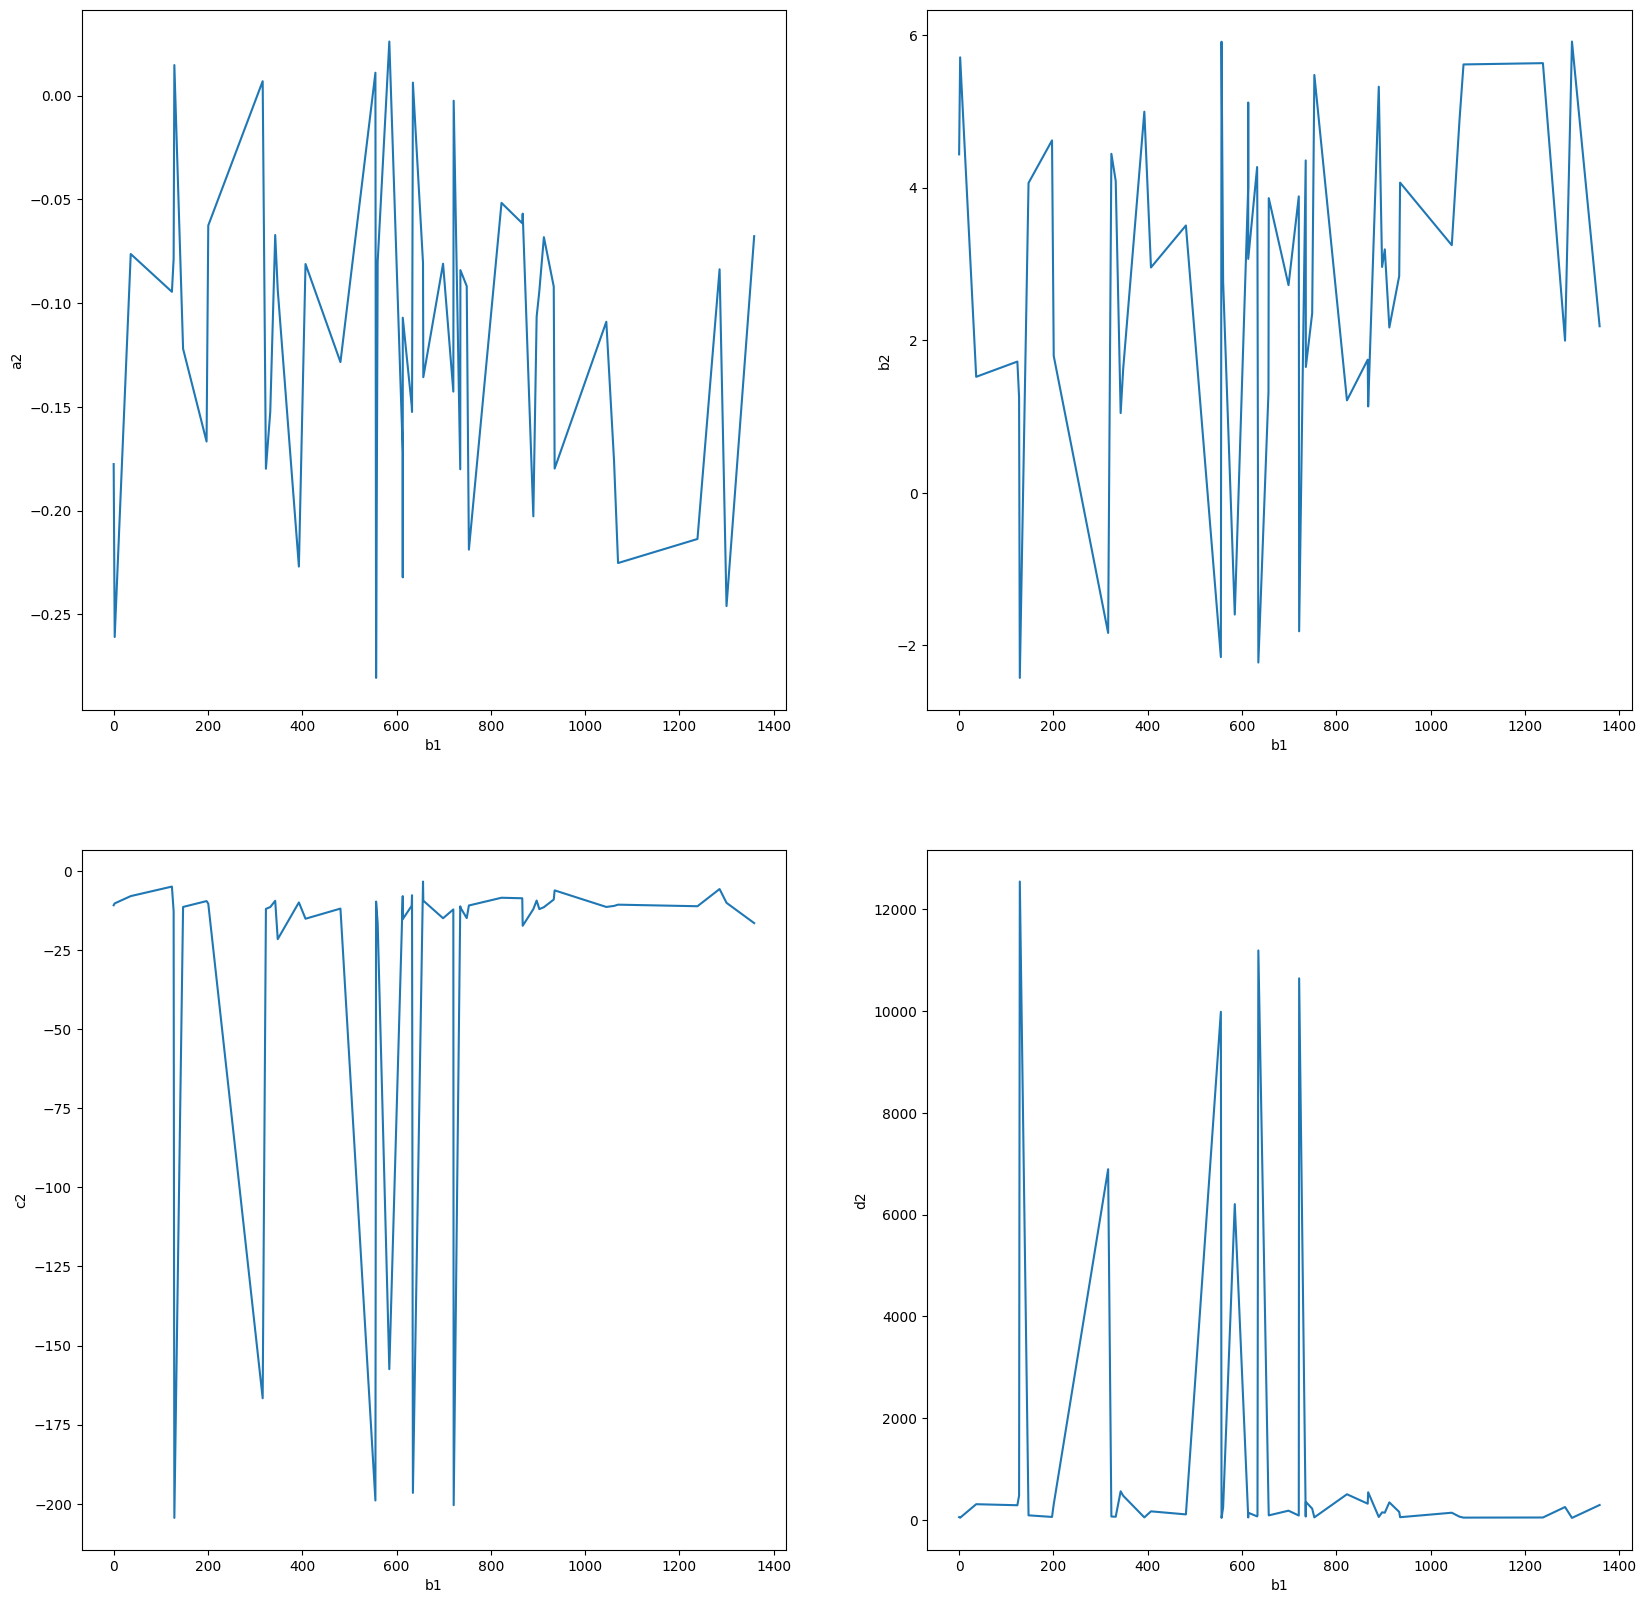

In [139]:
fig, axs = plt.subplots(2, 2, figsize=(20, 20))
axs[0, 0].plot(x, y1)
axs[0, 0].set(xlabel='b1', ylabel='a2')

axs[0, 1].plot(x, y2)
axs[0, 1].set(xlabel='b1', ylabel='b2')

axs[1, 0].plot(x, y3)
axs[1, 0].set(xlabel='b1', ylabel='c2')

axs[1, 1].plot(x, y4)
axs[1, 1].set(xlabel='b1', ylabel='d2')

Исследуем зависимость $a_2$, $b_2$ и $d_2$ от $b_1$

In [140]:
def fa(x, a, b, c):
    return a * x **2 + b * x + c

In [141]:
def fb(x, params):
    return x

In [142]:
def fc(x, *params):
    return np.mean(c2)

In [143]:
def fd(x, a, b, c):
    return a / x ** b + c

In [144]:
def check_model(xdata, ydata, model, plot=True):
    params, cov = scipy.optimize.curve_fit(model, xdata, ydata)
    ydata_pred = model(x, *params)
    if plot:
        plt.plot(x, ydata)
        plt.plot(x, ydata_pred)
        print(params)
    plt.show()
    _, pvalue = scipy.stats.normaltest(ydata - ydata_pred)
    return params, pvalue, pvalue > alpha, np.sqrt(np.diag(cov))

**Коэффициент $a_2$**

[-8.24453150e-08  8.29808848e-05 -1.27703139e-01]


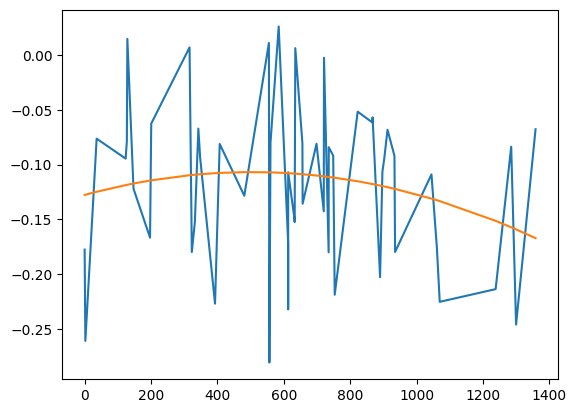

In [145]:
params1, _, _, _ = check_model(x, y1, fa)

**Коэффициент $b_2$**

[1.]


C:\Users\vladl\AppData\Local\Temp\ipykernel_2128\2061424025.py:2: OptimizeWarning: Covariance of the parameters could not be estimated
  params, cov = scipy.optimize.curve_fit(model, xdata, ydata)


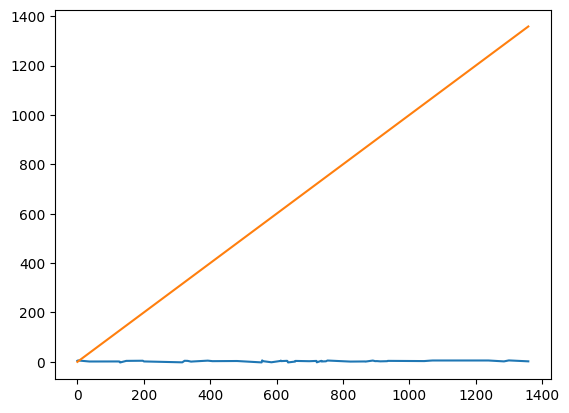

In [146]:
params2, _, _, _ = check_model(x, y2, fb)

Из графика не видно какой-либо зависимости между $b_1$ и $c_2$. Попробуем посмотреть на распределение $c_2$

**Коэффициент $c_2$**

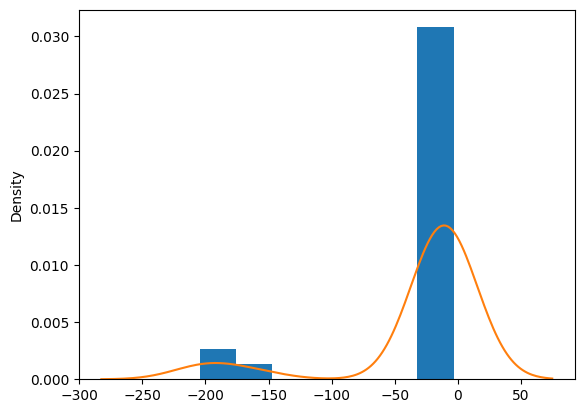

In [147]:
plt.hist(y3, bins=7, density=True)
sns.kdeplot(y3)
plt.show()

Здесь видно унимодальное распределение. Попробуем угадать какое именно мы тут имеем. Сначала проверим на количество уникальных значений

In [148]:
len(set(y3)), len(y3)

(52, 52)

Отсюда видно, что все значения в выборке уникальные. Теперь будем пробовать различные абсолютно-непрерывные распределения. Притом, у нас всего 49 значений в выборке, а значит нам понадобится критерий с достаточно большой скоростью сходимости. Возьмём критерий Колмогорова-Смринова и будем перебирать различные распределения.

In [149]:
_, pvalue = scipy.stats.kstest(y3, 'norm')
pvalue

np.float64(4.8819826377584926e-179)

Отсюда видно, что распределение очевидно не является нормальным

In [150]:
_, pvalue = scipy.stats.kstest(y3, scipy.stats.laplace.cdf)
pvalue

np.float64(2.515103725233135e-92)

Распределение Лапласа также не подходит

In [151]:
_, pvalue = scipy.stats.kstest(np.log(-y3), scipy.stats.norm.cdf)
pvalue

np.float64(2.519858708123276e-59)

Логнормальное распределение не подошло

**Коэффициент $d_2$**

[-6.68040414e-05 -2.40679352e+00  1.80878317e+03]


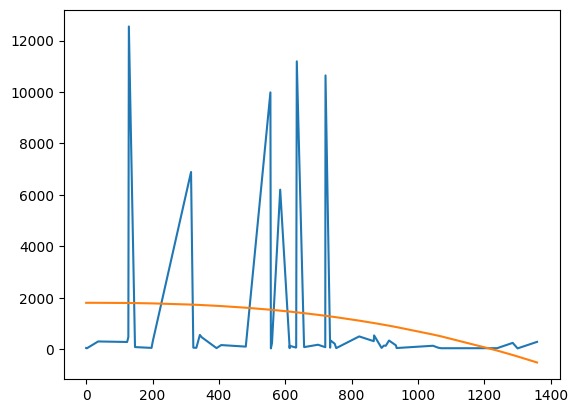

In [152]:
params4, _, _, _ = check_model(x, y4, fd)

In [153]:
y1_pred = fa(x, *params1)
y2_pred = fb(x, *params2)
y4_pred = fd(x, *params4)

Упрощаем нашу модель:

In [154]:
def new_check_fit(x, y, func1, func2, make_plots=True):
    m = x[np.argmax(y)]
    x1 = x[np.where(x <= m)]
    y1 = y[np.where(x <= m)]
    x2 = x[np.where(x >= m)]
    y2 = y[np.where(x >= m)]
    popt1, _ = scipy.optimize.curve_fit(func1, x1, y1)
    popt2, _ = scipy.optimize.curve_fit(func2, x2, y2)
    _, b1_, _ = popt1
    a2_ = fa(b1_, *params1)
    b2_ = fb(b1_, *params2)
    c2_ = fc(b1_)
    d2_ = fd(b1_, *params4)
    popt2_est = a2_, b2_, c2_, d2_
    y_pred = np.array(list(func1(x1, *popt1))[:-1] + list(func2(x2, *popt2)))
    _, pvalue = scipy.stats.normaltest(y - y_pred)
    print(popt2, popt2_est, sep='\n')
    if make_plots:
        plt.plot(x, y)
        plt.plot(x, y_pred, color='red' if pvalue < alpha else 'green')
        plt.show()

[ -0.20274421   5.32138132 -12.09913684  55.15652116]
(np.float64(-0.11915809071049761), np.float64(890.047118523676), np.float64(-33.07647107944741), np.float64(970.4226364554174))


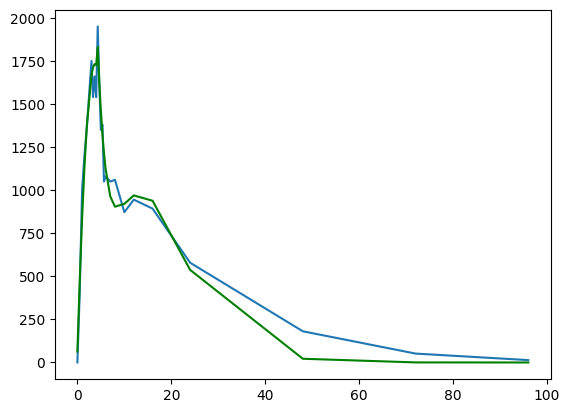

[-0.16668105  4.61766013 -9.55133529 56.32639726]
(np.float64(-0.1145511971007533), np.float64(197.0857186045215), np.float64(-33.07647107944741), np.float64(1786.5211807948515))


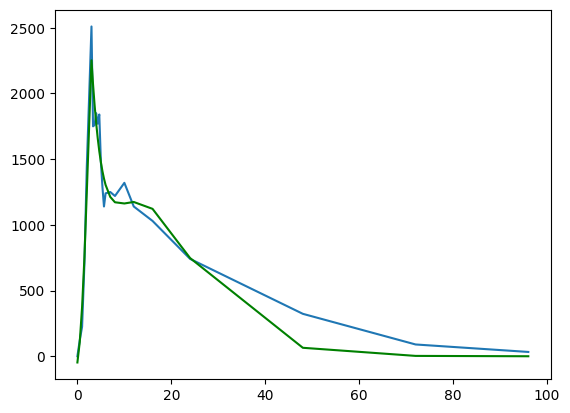

[-0.15244528  3.16041221 -7.70378756 85.52504861]
(np.float64(-0.10820720229779977), np.float64(632.8144212459955), np.float64(-33.07647107944741), np.float64(1439.89345630947))


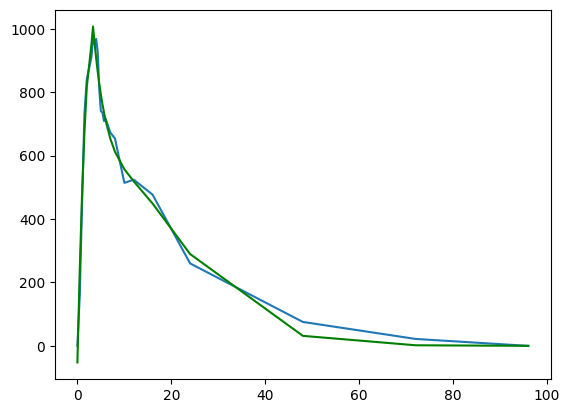

[-9.17910923e-02  2.35300786e+00 -1.49205064e+01  2.19211450e+02]
(np.float64(-0.11179541624066983), np.float64(748.8285685104322), np.float64(-33.07647107944741), np.float64(1255.6271033879145))


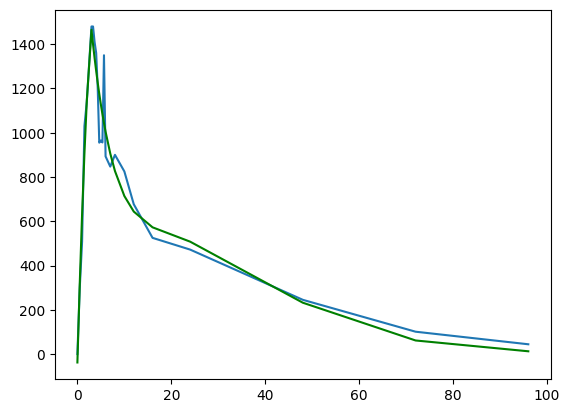

[-8.10044722e-02  2.72095145e+00 -1.49683778e+01  1.79011339e+02]
(np.float64(-0.10997033807749607), np.float64(698.6270665805325), np.float64(-33.07647107944741), np.float64(1340.7095666353428))


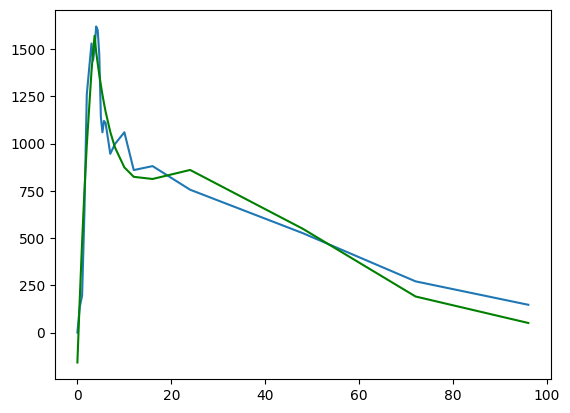

[-6.77356195e-02  2.18236007e+00 -1.65093007e+01  2.90756743e+02]
(np.float64(-0.16711819654289414), np.float64(1358.4285628651926), np.float64(-33.07647107944741), np.float64(-510.615535290867))


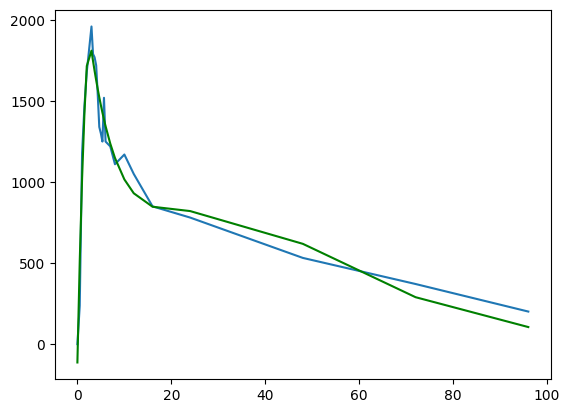

[ -0.21365403   5.62982365 -11.18046266  45.06212617]
(np.float64(-0.15135042790138997), np.float64(1238.1510880357405), np.float64(-33.07647107944741), np.float64(-46.75672206060085))


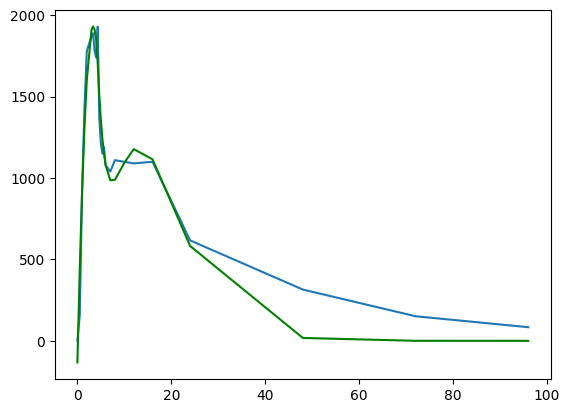

[ -0.26089187   5.7058536  -10.28185306  40.75671024]
(np.float64(-0.12751908383163937), np.float64(2.222954226203683), np.float64(-33.07647107944741), np.float64(1808.7827091449465))


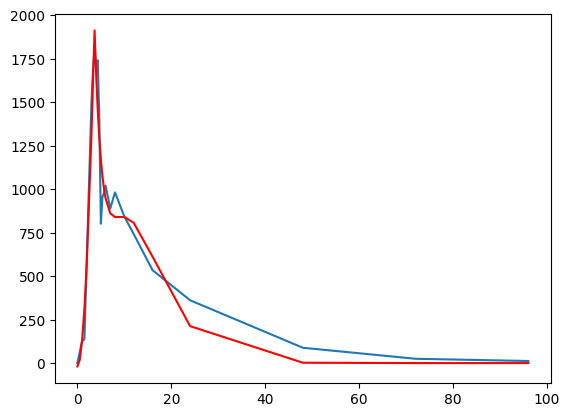

[ -0.12840707   3.50243142 -11.92510293 106.06868989]
(np.float64(-0.10686397812095809), np.float64(480.9961734645823), np.float64(-33.07647107944741), np.float64(1618.1652113494633))


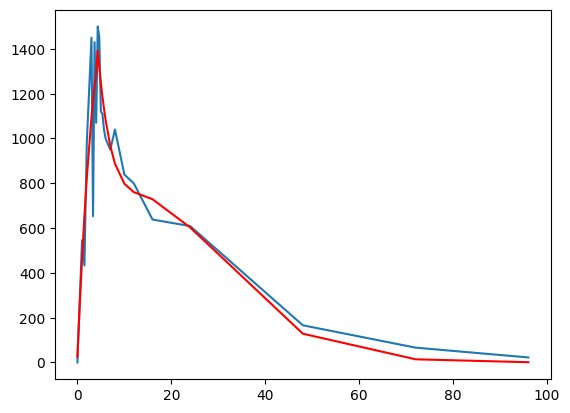

[ -0.12199527   4.06012329 -11.4047633   87.43675082]
(np.float64(-0.11727031679395153), np.float64(147.275771532203), np.float64(-33.07647107944741), np.float64(1797.7411820718464))


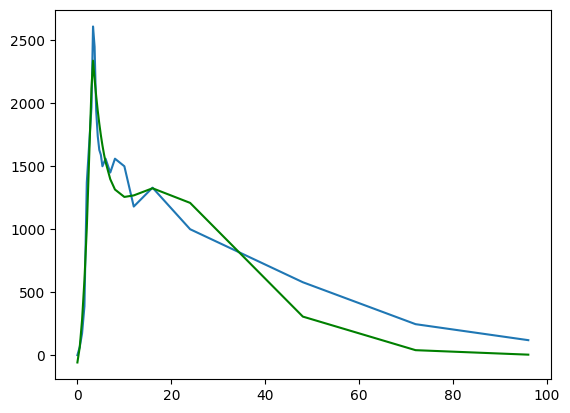

[-9.54059562e-02  2.00025072e+00 -7.76823211e+00  2.84085497e+02]
(np.float64(-0.1581598475399512), np.float64(-285.8499804895059), np.float64(-33.07647107944741), np.float64(nan))


C:\Users\vladl\AppData\Local\Temp\ipykernel_2128\3254944840.py:2: RuntimeWarning: invalid value encountered in scalar power
  return a / x ** b + c


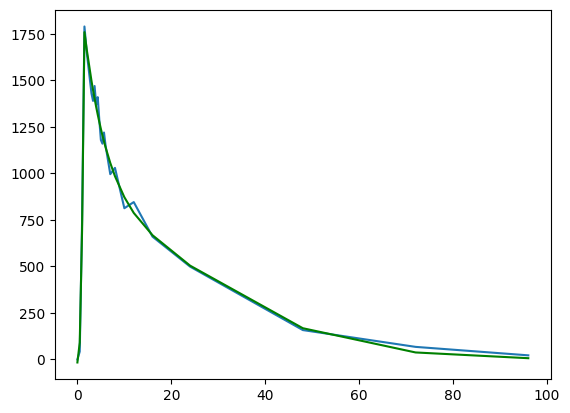

[ -0.17579808   4.87943931 -11.07812397  61.44681406]
(np.float64(-0.1324887964639951), np.float64(1061.195181751491), np.float64(-33.07647107944741), np.float64(528.6145446294186))


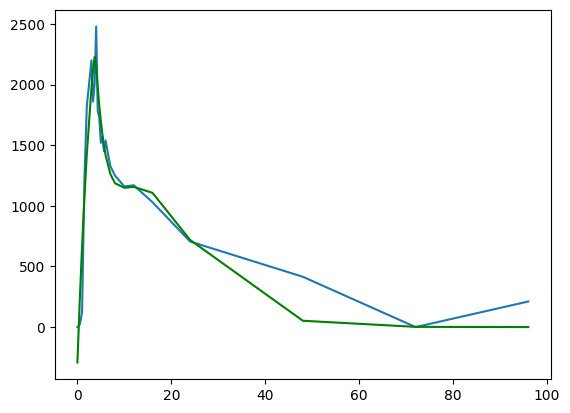

[ -0.22524049   5.61303532 -10.68324359  42.83847824]
(np.float64(-0.1332825225251982), np.float64(1069.7569245041273), np.float64(-33.07647107944741), np.float64(503.61493331825636))


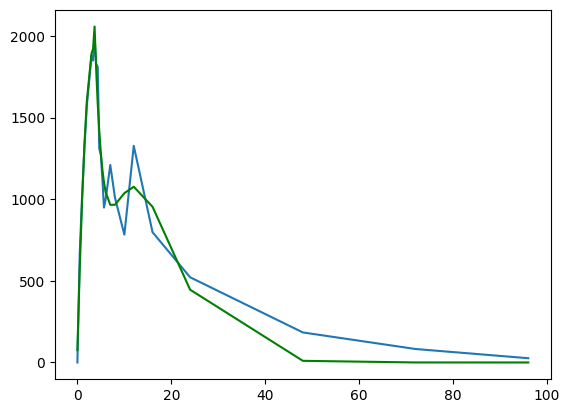

[ -0.17980791   4.44176144 -12.01274807  64.27870178]
(np.float64(-0.10950332050861919), np.float64(322.9471873105615), np.float64(-33.07647107944741), np.float64(1735.7089470816777))


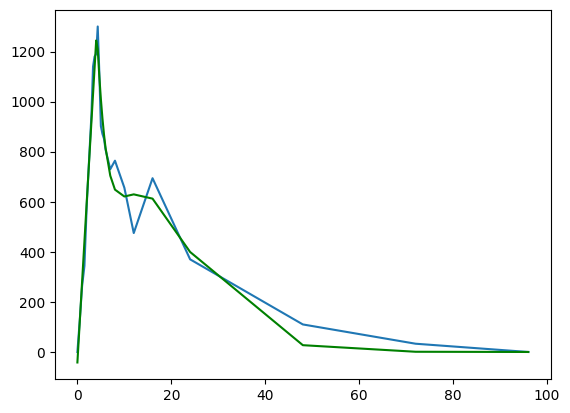

[-7.63166448e-02  1.51987846e+00 -7.97763666e+00  3.06461242e+02]
(np.float64(-0.12480346175770898), np.float64(36.249462370760845), np.float64(-33.07647107944741), np.float64(1808.4049676500147))


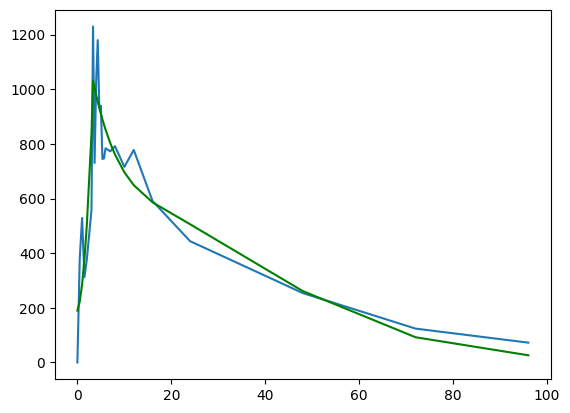

[ -0.14262589   3.88360322 -12.19261496  83.81352015]
(np.float64(-0.11071106272883358), np.float64(720.4055854627106), np.float64(-33.07647107944741), np.float64(1304.817779612794))


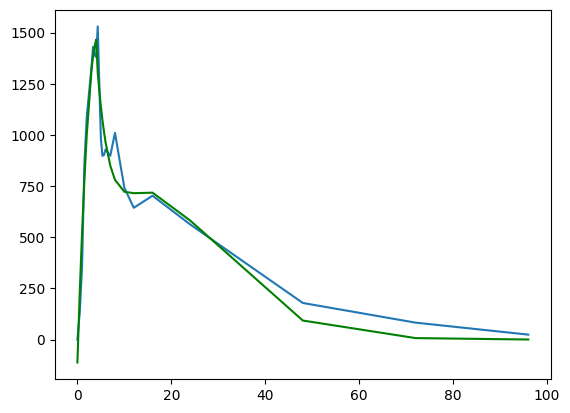

[-5.16826100e-02  1.21099911e+00 -8.49624284e+00  5.01944611e+02]
(np.float64(-0.11523020160193571), np.float64(822.5772928152405), np.float64(-33.07647107944741), np.float64(1115.307602612753))


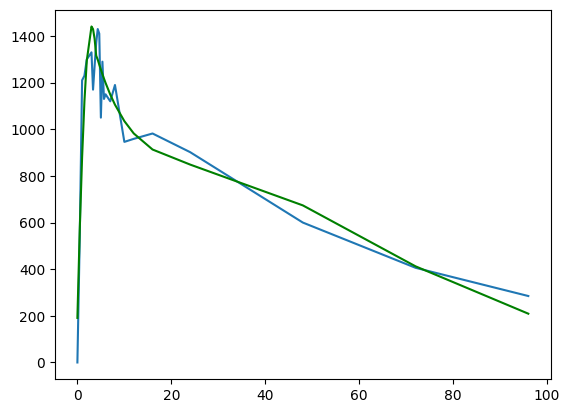

[-5.68768881e-02  1.13138423e+00 -1.73555997e+01  5.41514211e+02]
(np.float64(-0.11776453222044606), np.float64(867.5428457647149), np.float64(-33.07647107944741), np.float64(1020.5362007486052))


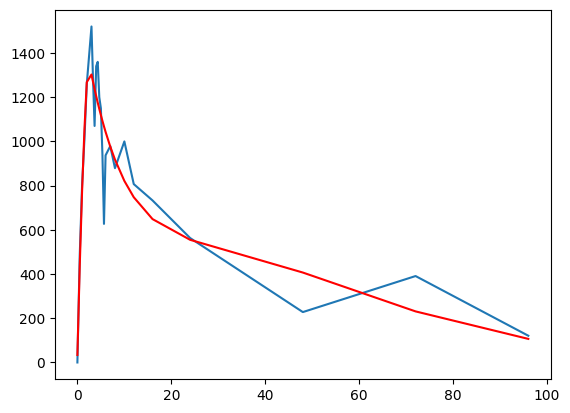

[-8.36791477e-02  1.99359638e+00 -5.74821588e+00  2.51116002e+02]
(np.float64(-0.1572191452255663), np.float64(1285.0828309400088), np.float64(-33.07647107944741), np.float64(-220.57174725247592))


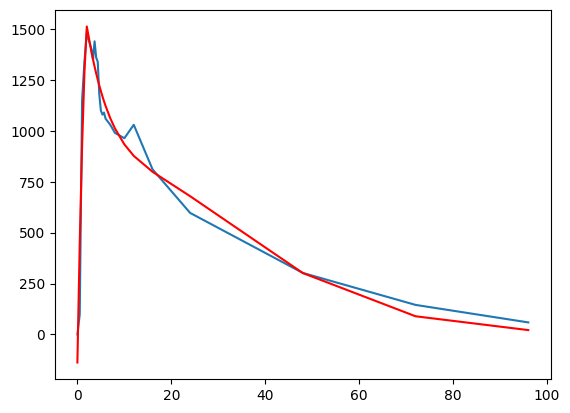

[-0.12874371  3.098222   -5.78757083 83.92706652]
(np.float64(-0.14306881490935444), np.float64(-159.80003225947326), np.float64(-33.07647107944741), np.float64(nan))


C:\Users\vladl\AppData\Local\Temp\ipykernel_2128\3254944840.py:2: RuntimeWarning: invalid value encountered in scalar power
  return a / x ** b + c


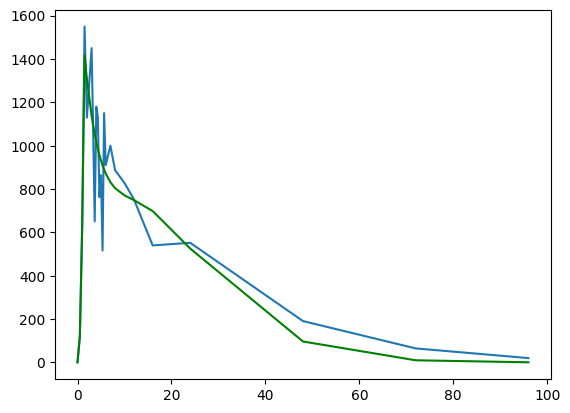

[ 2.60663320e-02 -1.59548732e+00 -1.57468535e+02  6.20610250e+03]
(np.float64(-0.10736938377740553), np.float64(584.644207781499), np.float64(-33.07647107944741), np.float64(1503.8956597864649))


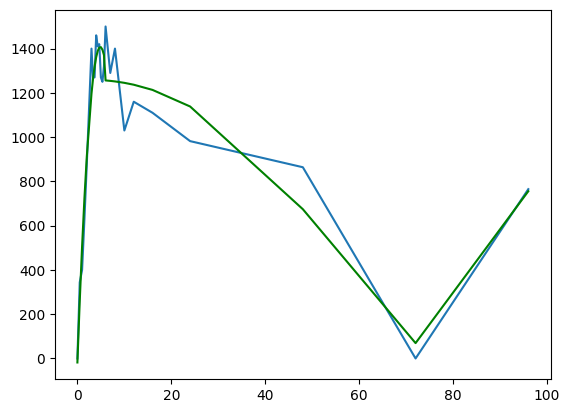

[-1.08959706e-01  3.24466369e+00 -1.14052156e+01  1.38974927e+02]
(np.float64(-0.1310076904067784), np.float64(1044.8570361662728), np.float64(-33.07647107944741), np.float64(575.5385001036068))


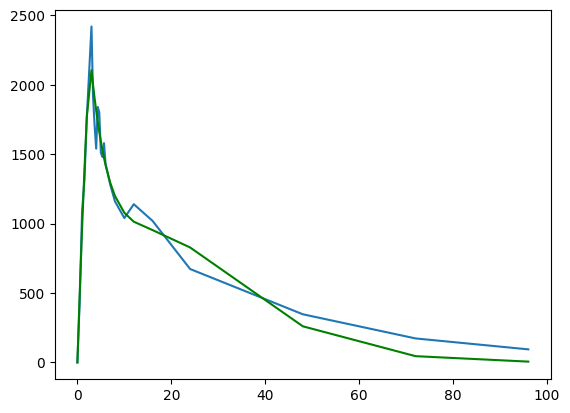

[-9.35906703e-02  1.62458678e+00 -2.15816311e+01  4.72807621e+02]
(np.float64(-0.10881024871995981), np.float64(347.9999977093888), np.float64(-33.07647107944741), np.float64(1721.3131553528242))


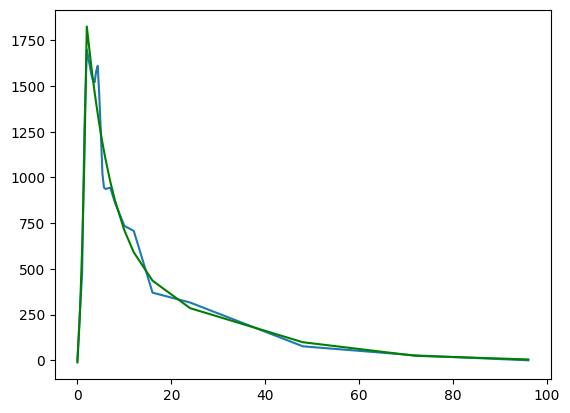

[-6.82135236e-02  2.16636830e+00 -1.14780405e+01  3.42144071e+02]
(np.float64(-0.1206292298497668), np.float64(912.4635627151935), np.float64(-33.07647107944741), np.float64(918.7006133742875))


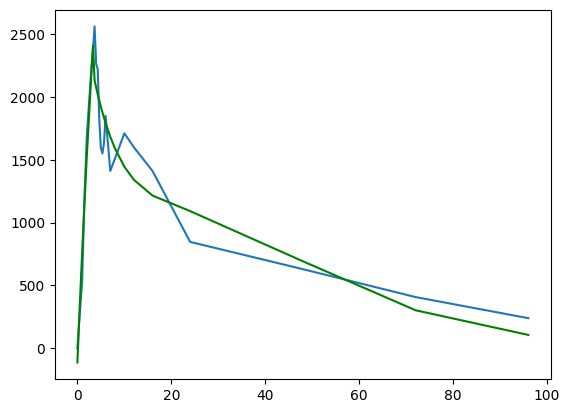

[-2.46802076e-03 -1.81496315e+00 -2.00447468e+02  1.06449856e+04]
(np.float64(-0.11073798392102477), np.float64(721.1561248903968), np.float64(-33.07647107944741), np.float64(1303.5531767218358))


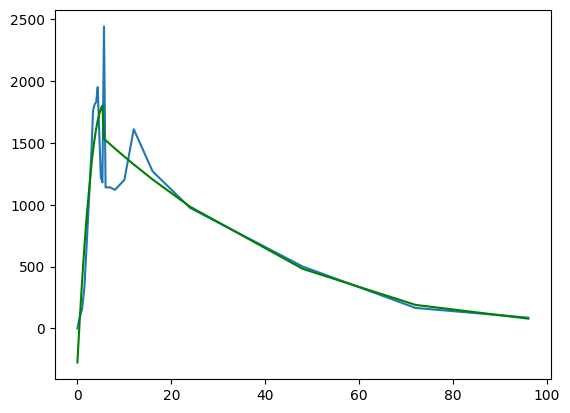

[-8.06311435e-02  1.31461969e+00 -3.37625016e+00  3.39553956e+02]
(np.float64(-0.10874974530426175), np.float64(656.1142806667577), np.float64(-33.07647107944741), np.float64(1406.3528268912346))


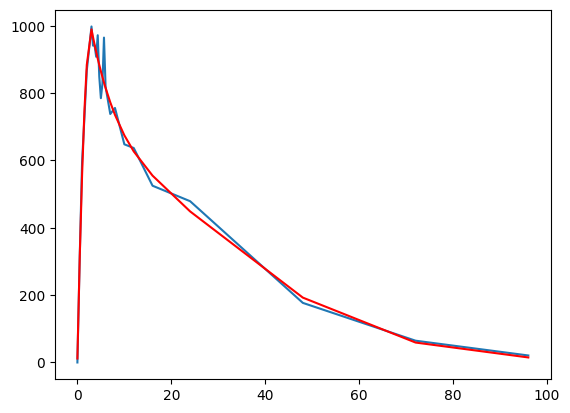

[-1.07010315e-01  3.06491010e+00 -1.52488684e+01  1.39169598e+02]
(np.float64(-0.10781975112092218), np.float64(613.1932744253511), np.float64(-33.07647107944741), np.float64(1466.8241582093192))


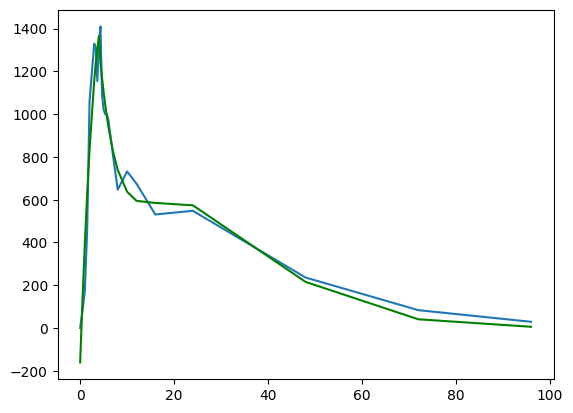

[-9.41403120e-02  3.18957047e+00 -1.20866478e+01  1.39539187e+02]
(np.float64(-0.11998568601135895), np.float64(902.8123512710573), np.float64(-33.07647107944741), np.float64(941.1909995881126))


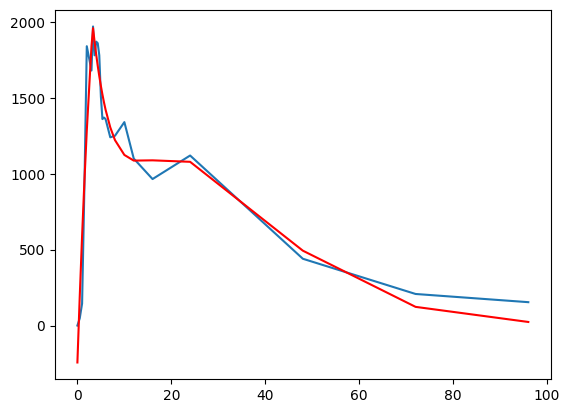

[-8.40881417e-02  1.64863533e+00 -1.15734626e+01  3.52616639e+02]
(np.float64(-0.11126623165840442), np.float64(735.3927860109522), np.float64(-33.07647107944741), np.float64(1279.2136664458365))


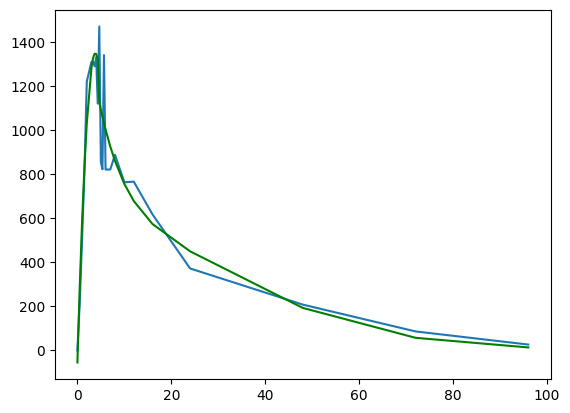

[ -0.24599537   5.91301525 -10.102653    37.10233796]
(np.float64(-0.15913050164392012), np.float64(1299.7710865343422), np.float64(-33.07647107944741), np.float64(-276.8471916153087))


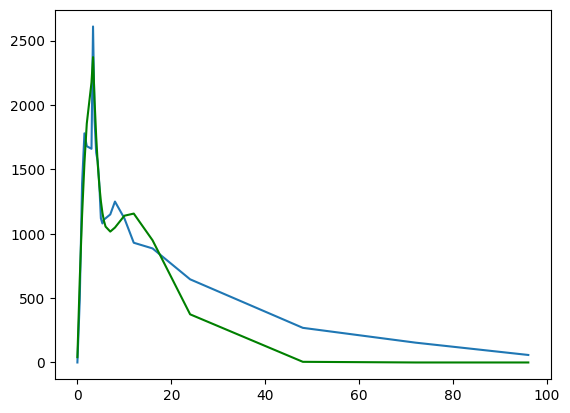

[-0.22694458  4.99421582 -9.98052814 47.39357801]
(np.float64(-0.10782766034634929), np.float64(392.86737231859), np.float64(-33.07647107944741), np.float64(1691.6669310735256))


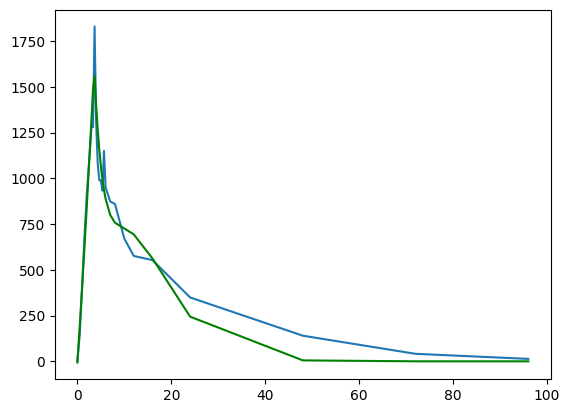

[ -0.17756342   4.43447283 -10.87098208  52.1462472 ]
(np.float64(-0.12769679350765917), np.float64(0.07647675805222565), np.float64(-33.07647107944741), np.float64(1808.7831658778741))


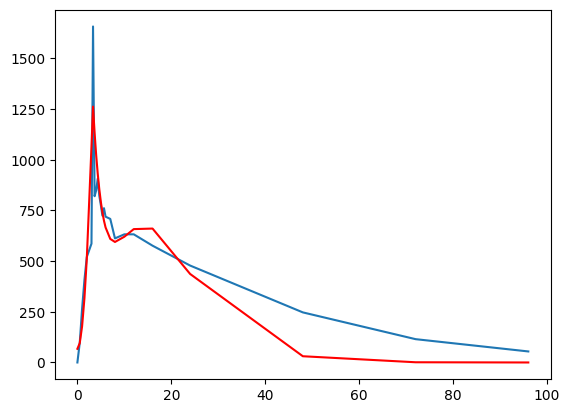

[-6.25617506e-02  1.79273271e+00 -1.03694923e+01  3.05076218e+02]
(np.float64(-0.11437010600860642), np.float64(200.6941316048167), np.float64(-33.07647107944741), np.float64(1785.5275277163062))


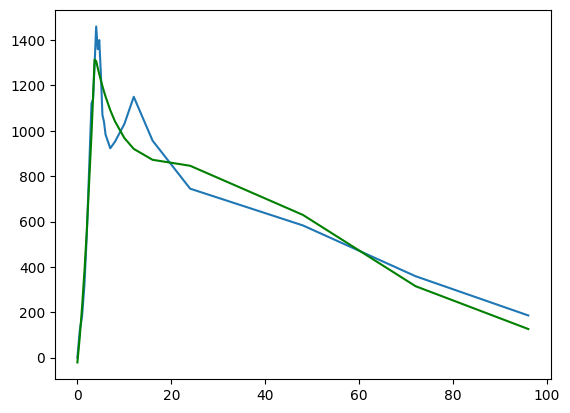

[-6.15112112e-02  1.74463825e+00 -8.66193181e+00  3.16822095e+02]
(np.float64(-0.11770741246122658), np.float64(866.5906958676356), np.float64(-33.07647107944741), np.float64(1022.6167604377173))


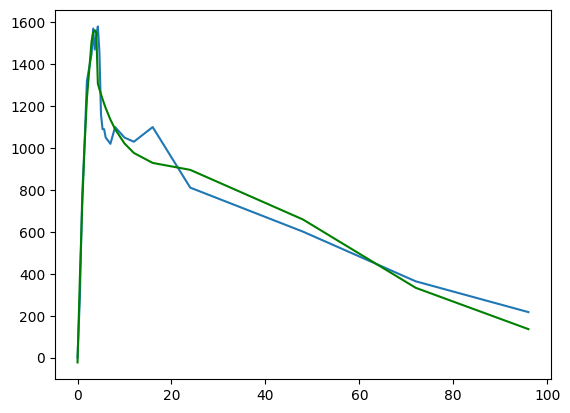

[ -0.21878744   5.47518064 -10.94498761  47.45940193]
(np.float64(-0.1119826354083654), np.float64(753.4092367422792), np.float64(-33.07647107944741), np.float64(1247.4481235106382))


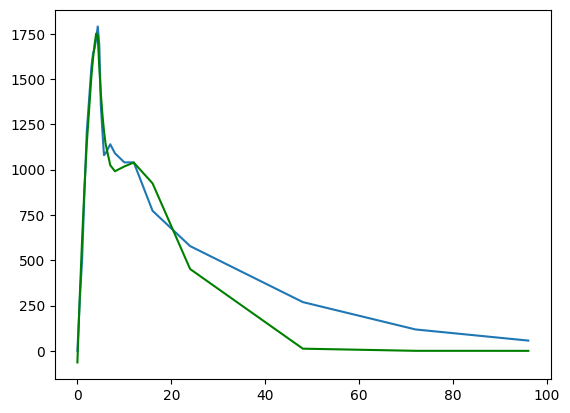

[-0.17139838  4.00781562 -7.98491436 57.50917671]
(np.float64(-0.10781850768682087), np.float64(613.1246646689058), np.float64(-33.07647107944741), np.float64(1466.9162386089367))


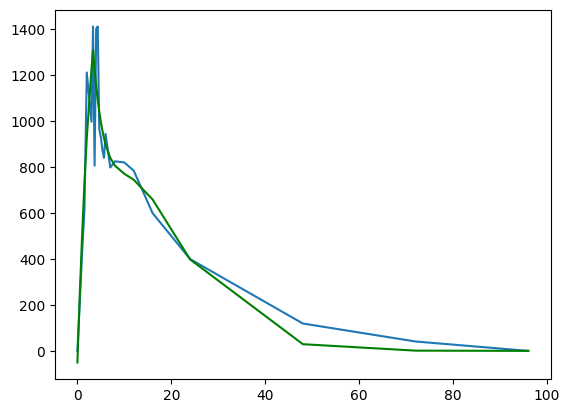

[-1.06542383e-01  2.95966017e+00 -9.37975929e+00  1.46413772e+02]
(np.float64(-0.11961137725509371), np.float64(897.090081596779), np.float64(-33.07647107944741), np.float64(954.3670851033593))


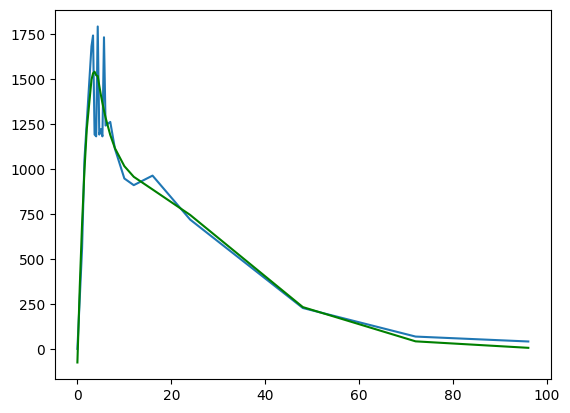

[-9.19914854e-02  2.84032702e+00 -9.06688684e+00  1.54837933e+02]
(np.float64(-0.12207553138513814), np.float64(933.3641863933984), np.float64(-33.07647107944741), np.float64(868.8379299151728))


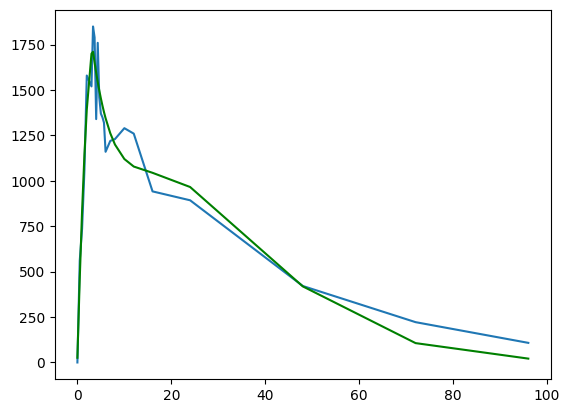

[-0.13567939  3.86073324 -9.4170926  86.79984589]
(np.float64(-0.10876570088992732), np.float64(656.7459775836669), np.float64(-33.07647107944741), np.float64(1405.4196738706182))


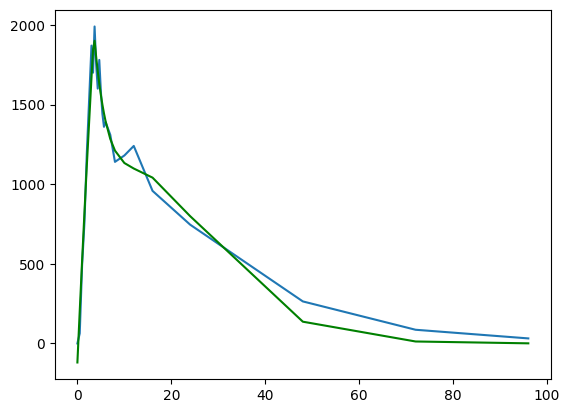

[-0.28059516  5.91048243 -9.70739871 37.29243847]
(np.float64(-0.10705780422495303), np.float64(556.5969834371817), np.float64(-33.07647107944741), np.float64(1537.9183140930386))


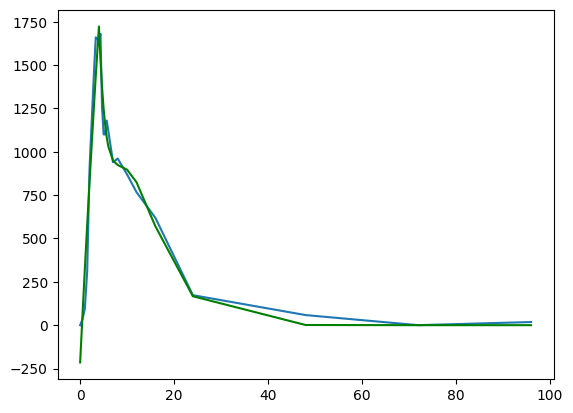

[ -0.18006425   4.35511895 -11.2099125   64.26929629]
(np.float64(-0.11125450746975338), np.float64(735.0862971276651), np.float64(-33.07647107944741), np.float64(1279.7447096214894))


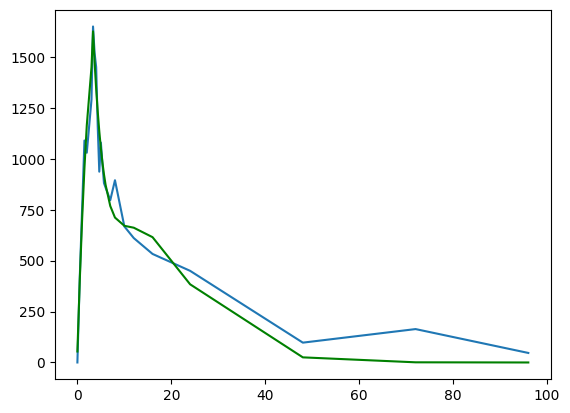

[-0.17972651  4.06434735 -6.16614971 50.78614459]
(np.float64(-0.12221007942033826), np.float64(935.2571445036394), np.float64(-33.07647107944741), np.float64(864.2433000523818))


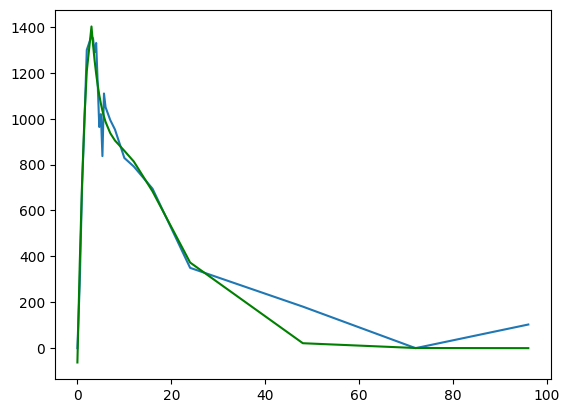

[ 6.27146524e-03 -2.22427725e+00 -1.96564402e+02  1.11930619e+04]
(np.float64(-0.10824683590084275), np.float64(634.6564608560391), np.float64(-33.07647107944741), np.float64(1437.3037731785885))


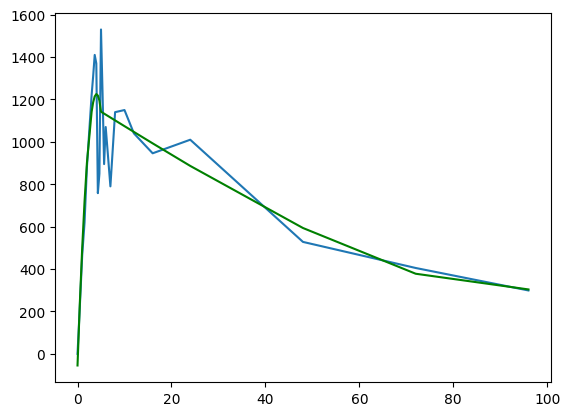

[ -0.14926331   4.26857211 -11.0445558   66.98838565]
(np.float64(-0.10819145142080512), np.float64(632.0750589341221), np.float64(-33.07647107944741), np.float64(1440.9299324504836))


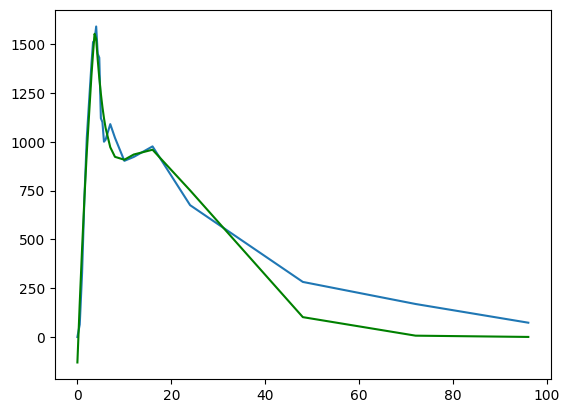

[-9.45383094e-02  1.71948464e+00 -4.96900612e+00  2.85972807e+02]
(np.float64(-0.11870708771985339), np.float64(123.5860680182887), np.float64(-33.07647107944741), np.float64(1801.5431186869178))


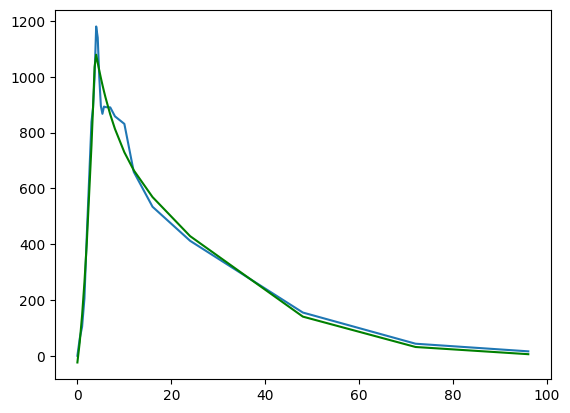

[-6.71604569e-02  1.04437820e+00 -9.46133541e+00  5.60275065e+02]
(np.float64(-0.10894987797025094), np.float64(342.6380991541735), np.float64(-33.07647107944741), np.float64(1724.5217500108072))


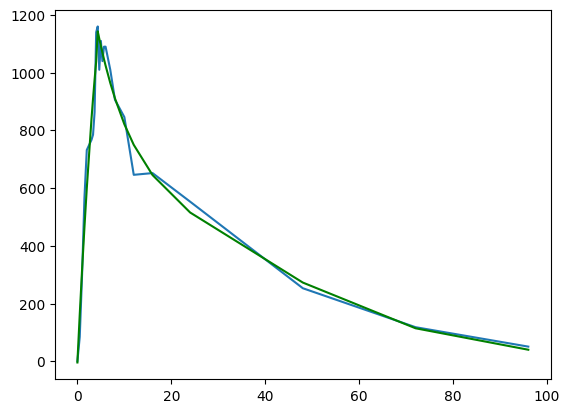

[-0.23213539  5.11401818 -9.14394012 46.27466353]
(np.float64(-0.1078192711671872), np.float64(613.1667967868428), np.float64(-33.07647107944741), np.float64(1466.8596952743046))


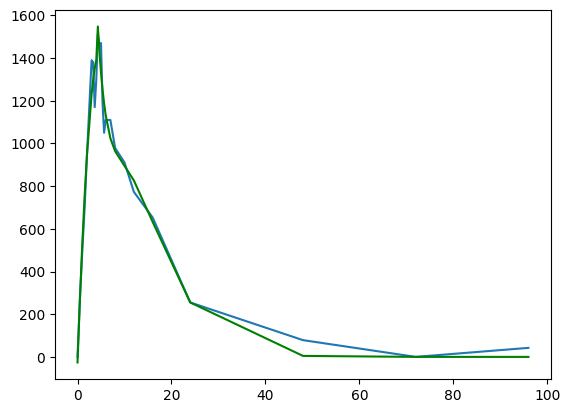

[ 1.47352438e-02 -2.42570256e+00 -2.04466840e+02  1.25480881e+04]
(np.float64(-0.1183854212044553), np.float64(128.75953730424786), np.float64(-33.07647107944741), np.float64(1800.7920738688479))


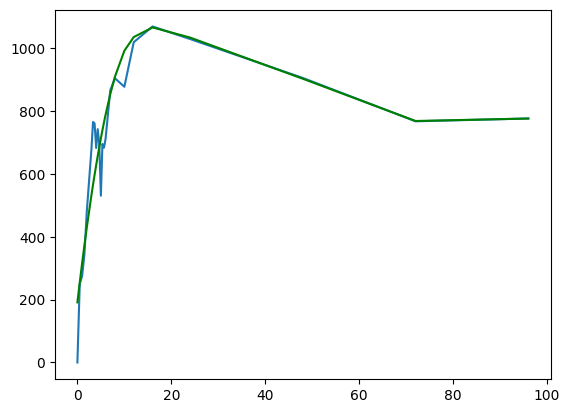

[-8.00862505e-02  2.76542689e+00 -1.65391076e+01  2.43491144e+02]
(np.float64(-0.10708818178252706), np.float64(559.945189414941), np.float64(-33.07647107944741), np.float64(1533.980111610561))


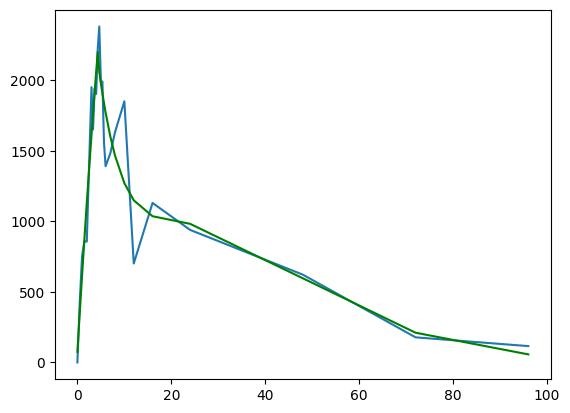

[ -0.15238683   4.08720616 -11.44155598  60.26768538]
(np.float64(-0.10923686719792884), np.float64(332.144217839704), np.float64(-33.07647107944741), np.float64(1730.5995980021937))


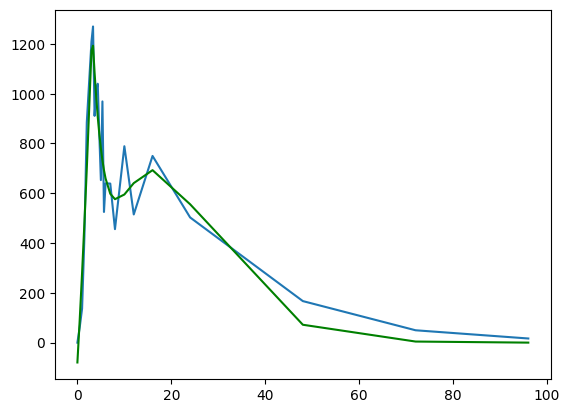

[-5.19412262e-02  1.65203133e+00 -1.99707167e+01  4.09747582e+02]
(np.float64(-0.13346037587511358), np.float64(-65.16164160518542), np.float64(-33.07647107944741), np.float64(nan))


C:\Users\vladl\AppData\Local\Temp\ipykernel_2128\3254944840.py:2: RuntimeWarning: invalid value encountered in scalar power
  return a / x ** b + c


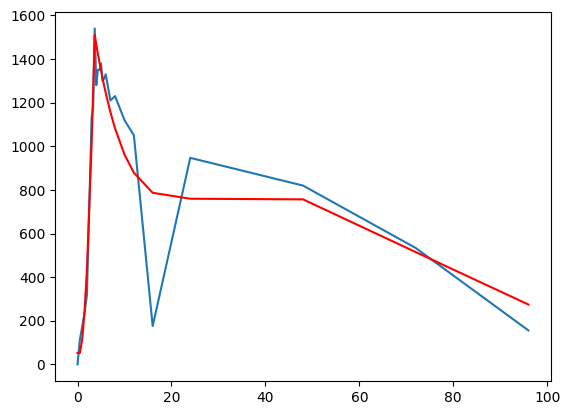

[-8.11336943e-02  2.95250629e+00 -1.51301371e+01  1.66090910e+02]
(np.float64(-0.10758809543701789), np.float64(406.92489440648916), np.float64(-33.07647107944741), np.float64(1681.3258580926506))


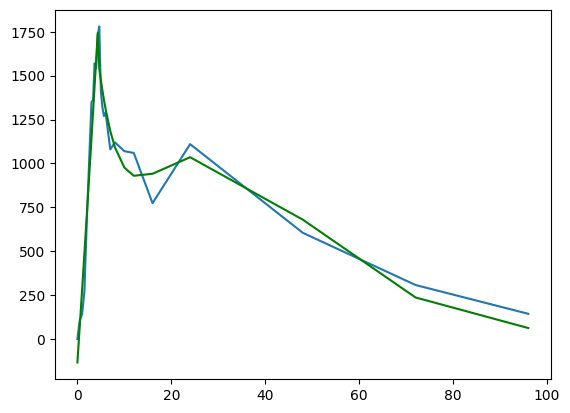

[-7.86650641e-02  1.25007166e+00 -1.27521121e+01  4.77848585e+02]
(np.float64(-0.11848022501265434), np.float64(127.22737838827466), np.float64(-33.07647107944741), np.float64(1801.0190211401114))


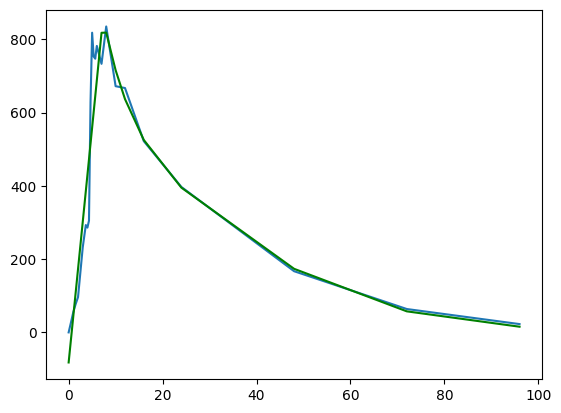

[ 6.96219584e-03 -1.83619423e+00 -1.66656366e+02  6.89227452e+03]
(np.float64(-0.10971139572504175), np.float64(316.0791474375837), np.float64(-33.07647107944741), np.float64(1739.393439918114))


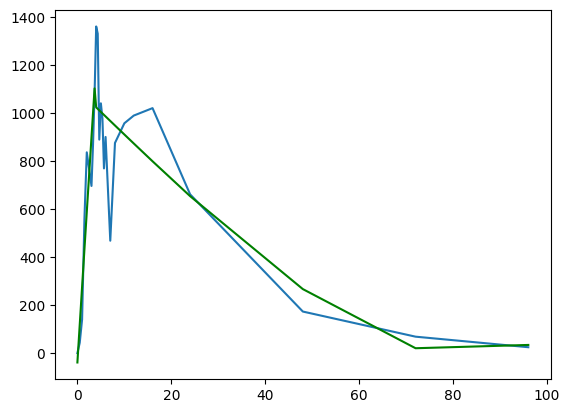

[ 7.26621132e-03 -1.96512971e+00 -1.87006987e+02  9.43621945e+03]
(np.float64(-0.13393707556648254), np.float64(-70.2252173664446), np.float64(-33.07647107944741), np.float64(nan))


C:\Users\vladl\AppData\Local\Temp\ipykernel_2128\3254944840.py:2: RuntimeWarning: invalid value encountered in scalar power
  return a / x ** b + c


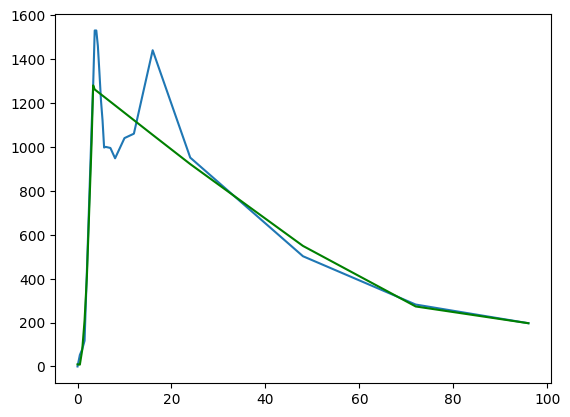

[ 1.10329948e-02 -2.15326280e+00 -1.98961655e+02  9.98709125e+03]
(np.float64(-0.10704528746020889), np.float64(555.1545983531149), np.float64(-33.07647107944741), np.float64(1539.6046332838005))


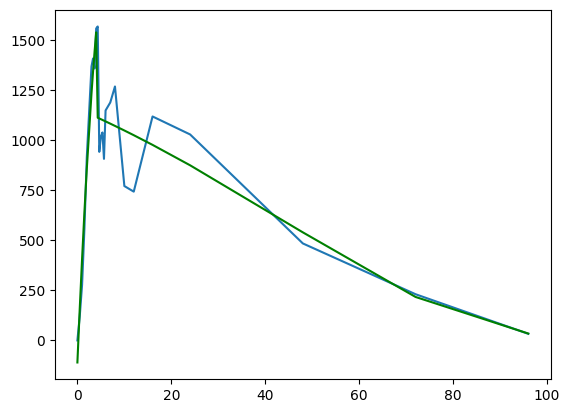

In [155]:
for i in range(len(df)):
    x = np.array([float(elem) for elem in df.drop(['area', 'max'], axis=1).columns])
    y = np.array(df.iloc[i,][:-2])
    try:
        new_check_fit(x, y, f1, f2)
    except RuntimeError:
        pass

In [156]:
pvalues = np.array(pvalues)
success = pvalues > alpha
np.mean(success)

np.float64(0.8571428571428571)